## KGB Model LN Auto V2 Without LDA and Variable Reduction

In [2]:
!pip install xgboost

  Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl (297.1 MB)

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import json
import logging
import xgboost as xgb
import ast
import itertools
import scipy.stats as ss
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2
import os
import sys

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', None)

In [4]:
sys.path.append('/root/Unified_LN_V2/')
from Utilities import *

In [5]:
Train = pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Mono_Data/3_Auto_Train_Binned_Data_260324.csv')
Test = pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Mono_Data/3_Auto_Test_Binned_Data_260324.csv')
Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Mono_Data/3_Auto_Oot_Binned_Data_260324.csv')
TTD= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Mono_Data/3_Auto_Ttd_Binned_Data_260324.csv')
# TTD_Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/1_LN_Auto_V2_OOT_Data_220324.csv')

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((146855, 145), (62938, 145), (37121, 144), (685215, 144))

In [6]:
req_cols= ['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'derogtimenewest', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'derogcount', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectrecordtimeoldest', 'addrcurrenttimenewest', 'proflictypecategory', 'criminalnonfelonytimenewest', 'lienjudgmentdollartotal', 'addrcurrentlastsalesprice', 'addrinputtimenewest', 'evictiontimenewest', 'bankruptcycount', 'addrcurrenttimelastsale', 'addrinputtimeoldest', 'addrlastmovetaxratiodiff', 'criminalnonfelonycount', 'sourcenonderogcount03month', 'addrchangecount03month', 'addrchangecount06month', 'addrchangecount12month', 'addrchangecount60month', 'addrcurrentavmratio60monthprior', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue60month', 'addrcurrentcorrectional', 'addrcurrentdeedmailing', 'addrcurrentphoneservice', 'addrcurrentsubjectowned', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmvalue12month', 'addrinputdeedmailing', 'addrinputphoneservice', 'addrinputproblems', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addronfilecollege', 'addronfilecorrectional', 'addronfilehighrisk', 'addrpreviouscorrectional', 'addrprevioussubjectowned', 'addrprevioustimeoldest', 'alertregulatorycondition', 'assetownership', 'assetpersonal', 'assetpersonalcount', 'assetprop', 'assetpropnewestmortgagetype', 'assetproppurchasecount12month', 'assetproppurchasetimenewest', 'assetpropsalepurchaseratio', 'assetpropsaletimenewest', 'assetpropsoldcount12month', 'bankruptcychapter', 'bankruptcycount24month', 'bankruptcydismissed24month', 'bankruptcystatus', 'bankruptcytimenewest', 'businessassociation', 'criminalfelonycount', 'criminalfelonycount12month', 'criminalfelonytimenewest', 'criminalnonfelonycount12month', 'derogcount12month', 'educationattendance', 'educationevidence', 'educationinstitutionrating', 'educationprogramattended', 'evictioncount', 'evictioncount12month', 'inquiryauto12month', 'inquirybanking12month', 'inquirycollections12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'lienjudgmentcount', 'lienjudgmentcount12month', 'lienjudgmentcourtcount', 'lienjudgmentforeclosurecount', 'lienjudgmentothercount', 'lienjudgmentsmallclaimscount', 'lienjudgmenttaxcount', 'lienjudgmenttimenewest', 'shorttermloanrequest', 'shorttermloanrequest12month', 'shorttermloanrequest24month', 'sourcecredheadertimenewest', 'sourcevoterregistration', 'subjectnewestrecord12month', 'subjectrecordtimenewest']
len(req_cols)

130

In [7]:
all_cols= ['unique_id', 'client', 'app_date', 'approve_flag', 'funded_flag', 'fico_pb', 'fico_cb', 'bad_flag', 'product', 'auto_score', 'bankcard_score', 'Race', 'Gender', 'age_cuts'] + req_cols
len(all_cols)

144

In [8]:
Train[all_cols].head()

,unique_id,client,app_date,approve_flag,funded_flag,fico_pb,fico_cb,bad_flag,product,auto_score,bankcard_score,Race,Gender,age_cuts,assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
0,319468,Tower,2017-04-13,1.0,1.0,857.0,NaN,0.0,Auto,777.0,789.0,white,M,Age 62 and over,"[1.0, 2.0)","[-inf, 2.0)","[-inf, 10.0)","[0.85, 1.01)",[-1],"[-inf, 510.0)","[280500.0, 363171.0)","[182000.0, 244673.0)","[120570.0, 208000.0)","[131500.0, 299200.0)","[421.0, inf)","[0.436, inf)","[15977.0, 324300.0)","[-inf, 90271.0)",[-1],"[-inf, 23.0)",[-1],"[-inf, 9000.0)","[159.0, inf)","[1.05, 1.47)","[-inf, 2.0)","[1.0, 2.0)","[2.0, inf)","[-inf, 2.0)","[246800.0, inf)","[-inf, 1.0)",[-1],"[0.91, 1.03)",[-1],"[-inf, 1.0)",[-1],[-1],"[1.01, 1.19)",[-1],"[-inf, 9.0)","[-inf, 1.33)","[1.02, 1.41)","[-inf, 1.0)","[-inf, 0.0454)","[-inf, 1.52)","[0.55, 0.89)",[-1],"[425.0, inf)","[4.755, inf)",[-1],[-1],"[-inf, 683.805)",[-1],[-1],[-1],"[-inf, 0.0352)",[-1],[-1],[-1],"[-inf, 0.0164)","[-inf, 2.0)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)","[1.66, inf)","[-inf

In [9]:
print({'Length': Train['funded_flag'].sum(), 'Bads': Train['bad_flag'].sum()})
print({'Length': Test['funded_flag'].sum(), 'Bads': Test['bad_flag'].sum()})
print({'Length': Oot['funded_flag'].sum(), 'Bads': Oot['bad_flag'].sum()})

{'Length': 146855.0, 'Bads': 2227.0}
{'Length': 62938.0, 'Bads': 959.0}
{'Length': 37121.0, 'Bads': 545.0}


In [10]:
Train.shape, Test.shape, Oot.shape

((146855, 145), (62938, 145), (37121, 144))

In [11]:
Train['wt2'].describe([0.9, 0.95, 0.99])

count    146855.000000
mean          1.669488
std           0.586060
min           1.060974
50%           1.487468
90%           2.326326
95%           2.722267
99%           3.905550
max          14.347176
Name: wt2, dtype: float64

In [12]:
Train.groupby('client')['wt2'].agg(['count', 'min', 'mean', 'max'])

,count,min,mean,max
client,,,,
Arkansas,27867,1.095290,1.583894,8.997074
Bethpage,8328,1.060974,1.453413,5.114712
CPM,6702,1.110488,1.601482,6.383648
GESA,19768,1.101697,1.810696,9.780985
Guardian,19177,1.101219,1.931245,13.497463
HFCU,2044,1.117645,1.662495,8.340647
Hawaii,1438,1.091428,1.775832,8.729644
NCU,595,1.142343,1.784662,5.058578
Numerica,18091,1.096292,1.770058,12.683987


In [13]:
Train= Train[all_cols + ['wt2']]
Test= Test[all_cols + ['wt2']]
Oot= Oot[all_cols]
TTD= TTD[all_cols]
# TTD_Oot= TTD_Oot[all_cols]

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((146855, 145), (62938, 145), (37121, 144), (685215, 144))

In [14]:
### Convert the Variable into categorical
var_to_cat= '''businesstitleleadership
proflictypecategory
addrcurrentdeedmailing
addrcurrentphoneservice
addrcurrentsubjectowned
addrinputdeedmailing
addrinputphoneservice
addrinputproblems
addrinputsubjectowned
addrlastmoveecontrajectory
addronfilecollege
addronfilecorrectional
addronfilehighrisk
addrprevioussubjectowned
alertregulatorycondition
assetownership
assetpersonal
assetprop
assetpropnewestmortgagetype
bankruptcychapter
bankruptcystatus
businessassociation
educationattendance
educationevidence
educationinstitutionrating
educationprogramattended
inquiryauto12month
inquirybanking12month
inquirycollections12month
inquirynonshortterm12month
inquiryshortterm12month
inquirytelcom12month
shorttermloanrequest
shorttermloanrequest12month
shorttermloanrequest24month
subjectnewestrecord12month
sourcevoterregistration'''.splitlines()
len(var_to_cat)

37

In [15]:
var_to_cat= list(set(var_to_cat))
len(var_to_cat)

37

In [16]:
for var in var_to_cat:
    Train[var]= [f"[{i}]" if i!= '[-1]' else i for i in Train[var].astype(str)]
    Test[var]= [f"[{i}]" if i!= '[-1]' else i for i in Test[var].astype(str)]
    Oot[var]= [f"[{i}]" if i!= '[-1]' else i for i in Oot[var].astype(str)]
    TTD[var]= [f"[{i}]" if i!= '[-1]' else i for i in TTD[var].astype(str)]

In [17]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))
print(Oot['bankruptcystatus'].value_counts(dropna= False))
print(TTD['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
[0]     141943
[1]       4543
[2]        337
[-1]        32
Name: count, dtype: int64
bankruptcystatus
[0]     60829
[1]      1941
[2]       157
[-1]       11
Name: count, dtype: int64
bankruptcystatus
[0]     35903
[1]      1132
[2]        84
[-1]        2
Name: count, dtype: int64
bankruptcystatus
[0]     648409
[1]      33203
[2]       3175
[-1]       428
Name: count, dtype: int64


In [18]:
Train[req_cols].isnull().sum()

assetpropevercount                 0
sourcenonderogcount06month         0
addronfilecount                    0
addrinputcountyratio               0
assetpropnewestsaleprice           0
addrcurrenttaxvalue                0
addrinputavmvalue                  0
addrinputavmvalue60month           0
addrinputlastsaleprice             0
addrinputtaxmarketvalue            0
sourcecredheadertimeoldest         0
addrinputphonecount                0
assetpropcurrenttaxtotal           0
addrcurrentavmvalue                0
assetproppurchasetimeoldest        0
addrpreviouslengthofres            0
addrinputlengthofres               0
addrcurrenttaxmarketvalue          0
addrprevioustimenewest             0
addrcurrenttractratio              0
sourcenonderogcount12month         0
assetpropcurrentcount              0
addrinputsubjectcount              0
sourcenonderogcount                0
addrinputtaxvalue                  0
assetpropeversoldcount             0
businessassociationtimeoldest      0
a

In [19]:
path_to_save= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Without_LDA/'

In [20]:
Train['funded_flag'].sum(), Train.shape, Train['bad_flag'].sum(), Train['bad_flag'].mean()

(146855.0, (146855, 145), 2227.0, 0.015164618160770828)

In [21]:
Test['funded_flag'].sum(), Test.shape, Test['bad_flag'].sum(), Test['bad_flag'].mean()

(62938.0, (62938, 145), 959.0, 0.015237217579204931)

In [22]:
def Bucket_Order(data):
    data['lower_bound'] = data['Bucket'].str.replace('[','').str.replace(']','').str.replace('(','').str.replace(')','').str.split(',').str[0]
    data['lower_bound'] = data['lower_bound'].apply(lambda x: -np.inf if x == '-inf' else np.inf if x == 'inf' else float(x))
    data = data.sort_values('lower_bound')
    a = data.loc[data['lower_bound']==-1]
    b = data.loc[data['lower_bound']!=-1]
    b['Is_Trend']= 'Yes' if (
            (b['Train_BadRate'].is_monotonic_decreasing and b['Test_BadRate'].is_monotonic_decreasing) or
            (b['Train_BadRate'].is_monotonic_increasing and b['Test_BadRate'].is_monotonic_increasing)
        ) else 'No'
    data = pd.concat(objs=[a,b])
    data = data.drop(columns=['lower_bound'])
    return data

In [23]:
df_bv= pd.DataFrame()

for col in req_cols:
    print(col)
    ### Train
    temp_tr= Train.groupby(col).agg(
        bad_count_tr= ('bad_flag', 'sum'),
        bad_rate_tr= ('bad_flag', 'mean'),
                                # p1_bad_rate_tr= ('p1', 'mean'),
                                   volume_tr= ('unique_id', 'count')).reset_index()
    temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_Count']#'Train_P1', 
    temp_tr.insert(0, 'variable', col)
    
    # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
    # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
    # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
    # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
    ### Test
    temp_te= Test.groupby(col).agg(
        bad_count_te= ('bad_flag', 'sum'),
        bad_rate_te= ('bad_flag', 'mean'),
                                # p1_bad_rate_te= ('p1', 'mean'),
                                  volume_te= ('unique_id', 'count')).reset_index()
    temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_Count']#'Test_P1', 
    #temp_te['variable']= col
    
    # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
    # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
    # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
    # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
    ### Concatenating
    temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
    # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
    temp= Bucket_Order(temp)
    # display(temp)
    
    df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
    del temp, temp_tr, temp_te

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
derogtimenewest
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
businesstitleleadership
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
derogcount
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
proflic

In [24]:
df_bv.head()

,variable,Bucket,Train_BadCount,Train_BadRate,Train_Count,Test_BadCount,Test_BadRate,Test_Count,Is_Trend
0,assetpropevercount,"[-inf, 1.0)",1526.0,0.030046,50788,663.0,0.030656,21627.0,Yes
1,assetpropevercount,"[1.0, 2.0)",445.0,0.008564,51963,204.0,0.009101,22414.0,Yes
2,assetpropevercount,"[2.0, 3.0)",155.0,0.006657,23283,57.0,0.005765,9887.0,Yes
3,assetpropevercount,"[3.0, inf)",101.0,0.004851,20821,35.0,0.003885,9010.0,Yes
4,sourcenonderogcount06month,"[-inf, 2.0)",1793.0,0.021940,81723,760.0,0.021714,35000.0,Yes


In [25]:
var_trend_break= list(df_bv[(df_bv['Is_Trend']== 'No') & (~(df_bv['variable'].isin(var_to_cat)))]['variable'].unique())
var_trend_break, len(var_trend_break)

(['assetpropnewestsaleprice',
  'addrinputavmvalue60month',
  'addrinputlastsaleprice',
  'assetpropcurrenttaxtotal',
  'addrcurrenttractratio',
  'businessassociationtimeoldest',
  'derogtimenewest',
  'educationinstitutionprivate',
  'addrinputavmratio60monthprior',
  'addrcurrentcountyratio',
  'assetpropsaletimeoldest',
  'criminalnonfelonytimenewest',
  'addrcurrentlastsalesprice',
  'evictiontimenewest',
  'bankruptcycount',
  'addrinputtimeoldest',
  'addrcurrentavmratio60monthprior',
  'addrinputavmvalue12month',
  'assetpropsaletimenewest',
  'bankruptcytimenewest',
  'criminalfelonycount12month',
  'criminalfelonytimenewest',
  'lienjudgmentothercount',
  'lienjudgmenttimenewest',
  'sourcecredheadertimenewest'],
 25)

In [26]:
var_trend_break= ['assetpropnewestsaleprice',
  'addrinputavmvalue60month',
  'addrinputlastsaleprice',
  'assetpropcurrenttaxtotal',
  'addrcurrenttractratio',
  'businessassociationtimeoldest',
  'derogtimenewest',
  'educationinstitutionprivate',
  'addrinputavmratio60monthprior',
  'addrcurrentcountyratio',
  'assetpropsaletimeoldest',
  'criminalnonfelonytimenewest',
  'addrcurrentlastsalesprice',
  'evictiontimenewest',
  'bankruptcycount',
  'addrinputtimeoldest',
  'addrcurrentavmratio60monthprior',
  'addrinputavmvalue12month',
  'assetpropsaletimenewest',
  'bankruptcytimenewest',
  'criminalfelonycount12month',
  'criminalfelonytimenewest',
  'lienjudgmentothercount',
  'lienjudgmenttimenewest',
  'sourcecredheadertimenewest']
len(var_trend_break), len(list(set(var_trend_break)))

(25, 25)

### Base Model Weighted Auto Without Segmentation Without FLA, LDA

In [27]:
!pip install hyperopt

  Using cached hyperopt-0.2.7-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [28]:
import numpy as np
import pandas as pd
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
import h2o
from h2o.estimators import H2OXGBoostEstimator
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
import warnings
warnings.filterwarnings('ignore')

In [29]:
### Starting H2o Session
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp1q5snlnl
  JVM stdout: /tmp/tmp1q5snlnl/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp1q5snlnl/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_unknownUser_mlbljk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.486 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [30]:
Train['unique_id']= Train['unique_id'].astype(str)
Test['unique_id']= Test['unique_id'].astype(str)
Oot['unique_id']= Oot['unique_id'].astype(str)
TTD['unique_id']= TTD['unique_id'].astype(str)

In [31]:
train_h2o = h2o.H2OFrame(Train)
test_h2o = h2o.H2OFrame(Test)
oot_h2o= h2o.H2OFrame(Oot)
ttd_h2o= h2o.H2OFrame(TTD)
print(Train.shape,train_h2o.shape,Test.shape,test_h2o.shape, oot_h2o.shape, ttd_h2o.shape)
bad_col = 'bad_flag'
Train[bad_col].mean(),Test[bad_col].mean()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
(146855, 145) (146855, 145) (62938, 145) (62938, 145) (37121, 144) (685215, 144)


(0.015164618160770828, 0.015237217579204931)

In [32]:
# for col in var_to_cat:
#     train_h2o[col] = train_h2o[col].asfactor()
#     test_h2o[col] = test_h2o[col].asfactor()
#     oot_h2o[col] = oot_h2o[col].asfactor()
#     ttd_h2o[col] = ttd_h2o[col].asfactor()

In [33]:
for k in Train['bankruptcychapter'].unique():
    print(k, train_h2o[train_h2o['bankruptcychapter']== k].shape)

[0] (141943, 145)
[1] (3731, 145)
[2] (1178, 145)
[-1] (3, 145)


In [34]:
train_h2o.head(rows= 2)

unique_id,client,app_date,approve_flag,funded_flag,fico_pb,fico_cb,bad_flag,product,auto_score,bankcard_score,Race,Gender,age_cuts,assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest,wt2
319468,Tower,2017-04-13 00:00:00,1,1,857,nan,0,Auto,777,789,white,M,Age 62 and over,"[1.0, 2.0)","[-inf, 2.0)","[-inf, 10.0)","[0.85, 1.01)",[-1],"[-inf, 510.0)","[280500.0, 363171.0)","[182000.0, 244673.0)","[120570.0, 208000.0)","[131500.0, 299200.0)","[421.0, inf)","[0.436, inf)","[15977.0, 324300.0)","[-inf, 90271.0)",[-1],"[-inf, 23.0)",[-1],"[-inf, 9000.0)","[159.0, inf)","[1.05, 1.47)","[-inf, 2.0)","[1.0, 2.0)","[2.0, inf)","[-inf, 2.0)","[246800.0, inf)","[-inf, 1.0)",[-1],"[0.91, 1.03)",[-1],"[-inf, 1.0)",[-1],[-1],"[1.01, 1.19)",[-1],"[-inf, 9.0)","[-inf, 1.33)","[1.02, 1.41)","[-inf, 1.0)","[-inf, 0.0454)","[-inf, 1.52)","[0.55, 0.89)",[-1],"[425.0, inf)","[4.755, inf)",[-1],[-1],"[-inf, 683.805)",[-1],[-1],[-1],"[-inf, 0.0352)",[-1],[-1],[-1],"[-inf, 0.0164)","[-inf, 2.0)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)","[1.66, inf)","[-inf, 

In [35]:
train_h2o[req_cols].head(rows= 2)

assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
"[1.0, 2.0)","[-inf, 2.0)","[-inf, 10.0)","[0.85, 1.01)",[-1],"[-inf, 510.0)","[280500.0, 363171.0)","[182000.0, 244673.0)","[120570.0, 208000.0)","[131500.0, 299200.0)","[421.0, inf)","[0.436, inf)","[15977.0, 324300.0)","[-inf, 90271.0)",[-1],"[-inf, 23.0)",[-1],"[-inf, 9000.0)","[159.0, inf)","[1.05, 1.47)","[-inf, 2.0)","[1.0, 2.0)","[2.0, inf)","[-inf, 2.0)","[246800.0, inf)","[-inf, 1.0)",[-1],"[0.91, 1.03)",[-1],"[-inf, 1.0)",[-1],[-1],"[1.01, 1.19)",[-1],"[-inf, 9.0)","[-inf, 1.33)","[1.02, 1.41)","[-inf, 1.0)","[-inf, 0.0454)","[-inf, 1.52)","[0.55, 0.89)",[-1],"[425.0, inf)","[4.755, inf)",[-1],[-1],"[-inf, 683.805)",[-1],[-1],[-1],"[-inf, 0.0352)",[-1],[-1],[-1],"[-inf, 0.0164)","[-inf, 2.0)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)","[1.66, inf)","[-inf, 76843.0)","[-inf, 69000.0)","[0.0, inf)",[0],[1],[0],"[242.0, inf)","[-inf, 1.33)","[256476.0, 313290.0)",[0],[1],[0],[1],[1],[0],[0],[0],"[0.0, inf)",[1],"[247.0, inf)",[1],[1],[0],"[-inf, 0.203)",[1],[-1],"[-inf, 0.07

In [36]:
# for var in var_to_cat:
#     print(var, ttd_h2o[var].unique())

### Baseline

In [37]:
req_cols_orig= req_cols.copy()
len(req_cols_orig), len(req_cols)

(130, 130)

In [38]:
barsath_list_to_drop= '''addrinputavmvalue
addrinputphonecount
addrinputavmvalue12month
sourcevoterregistration
addrinputblockratio
addrinputcountyratio
educationinstitutionrating
addrcurrentavmvalue12month
addrinputavmvalue60month
addrlastmoveecontrajectory
addrcurrentavmvalue
businesstitleleadership
assetpropeversoldcount
addrprevioussubjectowned
addrinputtractratio
addrcurrentcountyratio
addrcurrentavmvalue60month
addrcurrentavmratio60monthprior
educationevidence
assetpersonal
proflictypecategory
addrprevioustimenewest'''.splitlines()
len(barsath_list_to_drop), len(list(set(barsath_list_to_drop)))

(22, 22)

In [39]:
unique_cols = ['unique_id', 'client']
wt_col = 'wt2'
folds = 10
# predictors = train_h2o.columns
req_cols = [var for var in req_cols if var not in var_trend_break]
model_cols = unique_cols + [wt_col] + [bad_col] + req_cols
train_h2o[bad_col]= train_h2o[bad_col].asfactor()
len(req_cols)

105

In [40]:
train_h2o[req_cols].isna().sum()

0.0

### Run the Code

In [41]:
xgbm_auto_wt_segment_wt_lda_model = H2OXGBoostEstimator(
    ntrees=2000,    
    learn_rate=0.01,
    max_depth=2,    
    model_id="xgb_auto_wt_segment_without_lda_model",
    distribution = "bernoulli",    
    seed=42,
    nfolds = folds)#,    ignored_columns = unique_cols)

In [42]:
%%time
xgbm_auto_wt_segment_wt_lda_model.train(y=bad_col, x= req_cols, training_frame=train_h2o, weights_column =wt_col)

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
CPU times: user 16.2 s, sys: 1.1 s, total: 17.3 s
Wall time: 1h 14min 9s


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgb_auto_wt_segment_without_lda_model


Model Summary: 
    number_of_trees
--  -----------------
    2000

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.019837669743031427
RMSE: 0.14084626279398196
LogLoss: 0.08842521826446369
Mean Per-Class Error: 0.38264437375141735
AUC: 0.8080735981134919
AUCPR: 0.12266420675849611
Gini: 0.6161471962269838

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.07714436938027266
       0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      230993  8944   0.0373   (8944.0/239937.0)
1      3811    1423   0.7281   (3811.0/5234.0)
Total  234804  10367  0.052    (12755.0/245171.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0771444    0.182515  147
max f2                       0.0448255    0.256058  214
max f0point5                 0.139359     0.189963  80
max accuracy                 0.392093     0.978836  5
max precision                0.645622     1         0
max recall                   0.0014727    1         396
max specificity              0.645622     1         0
max absolute_mcc             0.0670961    0.170958  167
max min_per_class_accuracy   0.0246398    0.724846  277
max mean_per_class_accuracy  0.0232214    0.727522  283
max tns                      0.645622     239937    0
max fns                      0.645622     5222.88   0
max fps                      0.000910487  239937    399
max tps                      0.0014727    5235.24   396
max tnr                      0.645622     1         0
max fnr                      0.645622     0.997639  0
max fpr                      0.000910487  1         399
max tpr                      0.0014727    1         396

Gains/Lift Table: Avg response rate:  2.28 %, avg score:  2.90 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0115994                   0.13747            10.3127    10.3127            0.234845         0.213068    0.234845                    0.213068            0.119621        0.119621                   931.268   931.268            0.110539
2        0.0235919                   0.103032           5.19005    7.70869            0.11819          0.135354    0.175546                    0.173563            0.0622417       0.181862                   419.005   670.869            0.161959
3        0.0351304                   0.0874353          4.99391    6.81703            0.113724         0.11091     0.15524                     0.152985            0.0576222       0.239485                   399.391   581.703            0.209116
4        0.0466412                   0.0787038          3.78084    6.06771            0.0860991        0.0982558   0.138177                    0.139478            0.0435205       0.283005                   278.084   506.771            0.241872
5        0.0578807                   0.07245            3.63416    5.59515            0.0827586        0.0908977   0.127415                    0.130045            0.0408461       0.323851                   263.416   459.515            0.272168
6        0.113336                    0.0495764          2.67001    4.16388            0.0608027        0.0739442   0.0948217                   0.102595            0.148067        0.471918                   167.001   316.388            0.366938
7        0.16893                     0.035924

##### Train Predictions

In [43]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [44]:
def get_risk_rank(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    print(pred[weight].sum(),((pred[weight]*pred[target]).sum()),pred[weight].max())

    data_ks_cap5= rnkOrderingN(pred, target, weight, score_col, 5, asc)
    display(data_ks_cap5[0])
    print(data_ks_cap5[1])
    # data_ks_cap10= rnkOrderingN(pred, target, weight, score_col, 10, asc)
    # display(data_ks_cap10[0])
    # print(data_ks_cap10[1])

#### Weighted

In [45]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
245172.65465228388 5235.242054477501 14.3471756739957


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030310,0.645622,0.055160,49036.681823,45762.116652,3274.565171,6.68,20.0,19.07,62.55,43.48
1,0.017417,0.030310,0.023412,49032.910381,47935.808373,1097.102008,2.24,40.0,39.05,83.50,44.45
2,0.008569,0.017417,0.012292,49034.180782,48468.988889,565.191893,1.15,60.0,59.25,94.30,35.05
3,0.004490,0.008569,0.006302,49035.100263,48802.547234,232.553029,0.47,80.0,79.59,98.74,19.15
4,0.000500,0.004489,0.002844,49033.781403,48967.951449,65.829955,0.13,100.0,100.00,100.00,0.00


{'Gini': 56.85, 'KS': 44.45}


In [46]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
105130.63232533663 2219.2405799159274 14.729193454912512


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030592,0.398868,0.055500,21027.651001,19715.800126,1311.850875,6.24,20.0,19.16,59.11,39.95
1,0.017511,0.030591,0.023536,21024.727613,20539.219316,485.508298,2.31,40.0,39.12,80.99,41.87
2,0.008607,0.017511,0.012351,21027.366787,20775.084556,252.282231,1.20,60.0,59.30,92.36,33.06
3,0.004423,0.008606,0.006278,21025.813986,20906.589067,119.224919,0.57,80.0,79.62,97.73,18.11
4,0.000488,0.004422,0.002815,21025.072939,20974.698681,50.374258,0.24,100.0,100.00,100.00,0.00


{'Gini': 53.2, 'KS': 41.87}


#### Non-weighted

In [47]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
146855 2227.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024032,0.645622,0.044474,29372,27980.0,1392.0,4.74,20.0,19.35,62.51,43.16
1,0.011947,0.024032,0.017500,29370,28893.0,477.0,1.62,40.0,39.32,83.92,44.60
2,0.006553,0.011947,0.008844,29372,29136.0,236.0,0.80,60.0,59.47,94.52,35.05
3,0.003749,0.006553,0.005080,29371,29278.0,93.0,0.32,80.0,79.71,98.70,18.99
4,0.000500,0.003749,0.002471,29370,29341.0,29.0,0.10,100.0,100.00,100.00,0.00


{'Gini': 56.720000000000006, 'KS': 44.6}


In [48]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62938 959.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024109,0.398868,0.044751,12588,12014.0,574.0,4.56,20.0,19.38,59.85,40.47
1,0.011954,0.024105,0.017554,12588,12369.0,219.0,1.74,40.0,39.34,82.69,43.35
2,0.006539,0.011954,0.008857,12587,12492.0,95.0,0.75,60.0,59.50,92.60,33.10
3,0.003695,0.006538,0.005021,12588,12543.0,45.0,0.36,80.0,79.73,97.29,17.56
4,0.000488,0.003695,0.002451,12587,12561.0,26.0,0.21,100.0,100.00,100.00,0.00


{'Gini': 53.790000000000006, 'KS': 43.35}


In [49]:
Oot['wt2']= 1
TTD['wt2']= 1

In [50]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
37121 545.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024047,0.404056,0.044649,7425,7120.0,305.0,4.11,20.0,19.47,55.96,36.49
1,0.012058,0.024047,0.017550,7424,7285.0,139.0,1.87,40.0,39.38,81.47,42.09
2,0.006578,0.012058,0.008919,7424,7362.0,62.0,0.84,60.0,59.51,92.84,33.33
3,0.003742,0.006578,0.005072,7424,7403.0,21.0,0.28,80.0,79.75,96.70,16.95
4,0.000529,0.003742,0.002483,7424,7406.0,18.0,0.24,100.0,100.00,100.00,0.00


{'Gini': 51.54, 'KS': 42.09}


In [51]:
var_imp = xgbm_auto_wt_segment_wt_lda_model._model_json['output']['variable_importances'].as_data_frame()
var_imp['Var_unique'] = var_imp['variable'].str.split('.', expand=True)[0]
var_imp_list_baseline1 = list(var_imp['Var_unique'].unique())

print(var_imp_list_baseline1, len(var_imp_list_baseline1))

['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'addrinputcountyratio', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'derogcount', 'addrcurrenttaxmarketvalue', 'criminalnonfelonycount', 'addrinputtaxvalue', 'evictioncount', 'derogcount12month', 'addrprevioustimeoldest', 'sourcevoterregistration', 'addrinputtimenewest', 'educationinstitutionrating', 'addrcurrentavmvalue60month', 'criminalfelonycount', 'addrinputlengthofres', 'addrchangecount03month', 'educationevidence', 'addrlastmoveecontrajectory', 'inquirycollections12month', 'bankruptcydismissed24month', 'inquirybanking12month', 'bankruptcychapter', 'lienjudgmentcount', 'addrcurrentavmvalue', 'addrchangecount24month', 'addrcurrentdeedmailing', 'educationattendance', 'addrinputtaxmarketvalue', 'addrinputsubjectcount', 'addrpreviouslengthofres', 'addrinputdeedmailing', 'assetpersonal', 'bankruptcystatus',

In [52]:
var_imp

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,assetownership.[0],64439.054688,1.000000,0.183842,assetownership
1,inquiryauto12month.[0],63451.371094,0.984673,0.181024,inquiryauto12month
2,inquiryshortterm12month.[0],25449.980469,0.394947,0.072608,inquiryshortterm12month
3,"sourcenonderogcount12month.[-inf, 2.0)",22035.537109,0.341959,0.062866,sourcenonderogcount12month
4,"assetpropevercount.[-inf, 1.0)",16286.637695,0.252745,0.046465,assetpropevercount
5,inquirytelcom12month.[0],14734.498047,0.228658,0.042037,inquirytelcom12month
6,"sourcenonderogcount.[4.0, 5.0)",7213.692383,0.111946,0.020580,sourcenonderogcount
7,"addrinputcountyratio.[1.32, inf)",7144.341309,0.110870,0.020382,addrinputcountyratio
8,"addrlastmovetaxratiodiff.[-inf, 0.166)",6620.041016,0.102733,0.018887,addrlastmovetaxratiodiff
9,"sourcenonderogcount.[5.0, inf)",5947.056641,0.092290,0.016967,sourcenonderogcount


## HyperOpt

In [63]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# test_h2o[bad_col] = test_h2o[bad_col].asfactor()
# oot_h2o[bad_col] = oot_h2o[bad_col].asfactor()
col_list = var_imp_list_baseline1
# len(col_list)
# 82
# col_list = ['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'addrinputcountyratio', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'derogcount', 'addrcurrenttaxmarketvalue', 'criminalnonfelonycount', 'addrinputtaxvalue', 'evictioncount', 'derogcount12month', 'addrprevioustimeoldest', 'sourcevoterregistration', 'addrinputtimenewest', 'educationinstitutionrating', 'addrcurrentavmvalue60month', 'criminalfelonycount', 'addrinputlengthofres', 'addrchangecount03month', 'educationevidence', 'addrlastmoveecontrajectory', 'inquirycollections12month', 'bankruptcydismissed24month', 'inquirybanking12month', 'bankruptcychapter', 'lienjudgmentcount', 'addrcurrentavmvalue', 'addrchangecount24month', 'addrcurrentdeedmailing', 'educationattendance', 'addrinputtaxmarketvalue', 'addrinputsubjectcount', 'addrpreviouslengthofres', 'addrinputdeedmailing', 'assetpersonal', 'bankruptcystatus', 'educationprogramattended', 'addrchangecount06month', 'criminalnonfelonycount12month', 'lienjudgmenttaxcount', 'addrinputavmvalue', 'assetpropnewestmortgagetype', 'addrcurrentlengthofres', 'addrcurrentblockratio', 'addrcurrentavmvalue12month', 'sourcenonderogcount06month', 'addrinputtimelastsale', 'assetproppurchasetimeoldest', 'lienjudgmentsmallclaimscount', 'addrcurrenttimeoldest', 'assetpropsalepurchaseratio', 'lienjudgmentcourtcount', 'assetproppurchasetimenewest', 'addrprevioustimenewest', 'addrchangecount60month', 'businesstitleleadership', 'proflictypecategory', 'subjectrecordtimeoldest', 'bankruptcycount24month', 'sourcecredheadertimeoldest', 'addrinputtractratio', 'shorttermloanrequest', 'lienjudgmentdollartotal', 'addrinputblockratio', 'addrcurrenttimenewest', 'addrprevioussubjectowned', 'addrcurrentavmratio12monthprior', 'subjectrecordtimenewest', 'evictioncount12month', 'assetpropcurrentcount', 'addrcurrentsubjectowned', 'addrinputsubjectowned', 'addronfilecount', 'lienjudgmentcount12month', 'addrinputphoneservice', 'addrinputproblems', 'addronfilecollege']
len(col_list)

82

In [64]:
from IPython.display import clear_output


def get_predictions(data_h2o, bad_col, wt_col, classifier):
    predict = classifier.predict(data_h2o)
    p = predict.as_data_frame()
    dd = pd.DataFrame(data_h2o[:, unique_cols + [bad_col] + [wt_col] + ['age_cuts','Race','Gender']].as_data_frame())
    dd['RECWGT'] = dd[wt_col]
    dd['con_wt'] = 1
    dd['bad'] = dd[bad_col]
    pred = pd.concat([dd.loc[:, ('bad', "RECWGT", 'con_wt', 'age_cuts','Race','Gender')], p], axis=1)
    return pred


def find_cutoff(pred):
    sorted_pred = pred.sort_values(by='p1').reset_index(drop= True)
    cum_bad = sorted_pred['bad'].cumsum()
    bad_rate= sorted_pred['bad'].mean()
    cum_p1 = sorted_pred['p1'].cumsum()
    total_bad = cum_bad.iloc[-1]
#     total_bad= bad_rate
    cutoff_idx = (cum_p1 >= total_bad).idxmax()
    cutoff = sorted_pred.loc[cutoff_idx, 'p1']
    
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    print('Last Row')
    display(pd.DataFrame(sorted_pred.iloc[-1]).T)
    print('Cutoff Index Row')
    display(pd.DataFrame(sorted_pred.iloc[cutoff_idx]).T)
    
    print({'total_bad': total_bad, 'bad_rate': bad_rate, 'cutoff': cutoff, 'total_predicted': cum_p1.iloc[-1], 'max_prob': pred['p1'].max()})
    
    return cutoff

def Equal_Approval_Cutoff_Barsath(pred, target, score_col):
    pred= pred.copy()
    actual_approved_count= pred[target].sum()
    pred= pred.sort_values(by= [score_col])
    pred['con_wt']= 1
    pred['cumsum']= pred['con_wt'].cumsum()
    pred['approved']= np.where(pred['cumsum']<= actual_approved_count, 1, 0)
    return pred #cutoff, original_dataset

def find_cutoff_2(pred):
    pred= pred.copy()
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    prev_min = 1
    for k in range(1,100,1):
        pred["model_approval"] = [1 if i>k/100 else 0 for i in pred['p1']]
        a,b = pred.describe().loc['mean',['model_approval','bad']]
        if prev_min < abs(a-b):
            pred["model_approval"] = [1 if i>(k-1)/100 else 0 for i in pred['p1']]
            break
        else:
            prev_min = abs(a-b)
    print({'cutoff': (k-1)/100})
    return (k-1)/100

def air_calc(pred,prefix):
    air = {}
    target_control_dict = {
        'age_cuts': {
            'target': ['Age 62 and over'],
            'control': ['Age below 62']
        },
        'Race': {
            'target': ['black', 'hispanic'],
            'control': ['white']
        },
        'Race': {
            'target': ['black'],
            'control': ['white']
        },
        'Race': {
            'target': ['hispanic'],
            'control': ['white']
        },
        'Gender': {
            'target': ['F'],
            'control': ['M']
        },
        # 'mmct_tag': {
        #     'target': ['mmct'],
        #     'control': ['non-mmct']
        # }
    }
    
    for var in target_control_dict:
        target_list = target_control_dict[var]['target']
        control_list = target_control_dict[var]['control']
        p_target_list= ','.join(target_list)
        ttd_target= pred[pred[var].isin(target_list)]['con_wt'].sum()
        approved_target= pred[pred[var].isin(target_list)]['approved'].multiply(pred[pred[var].isin(target_list)]['con_wt']).sum()
        ttd_control= pred[pred[var].isin(control_list)]['con_wt'].sum()
        approved_control= pred[pred[var].isin(control_list)]['approved'].multiply(pred[pred[var].isin(control_list)]['con_wt']).sum()
        app_pct_target= round(approved_target/ttd_target, 4)
        app_pct_control= round(approved_control/ttd_control, 4)
        air[prefix+var+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
        print({'variable': var, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
               'approved_target': approved_target, 'approved_control': approved_control})
    print(air)
        
    return air

def air_calc_new(pred,prefix):
    air = {}
    target_control_dict = [
            {'age_cuts': {
                'target': ['Age 62 and over'],
                'control': ['Age below 62']
            }},
            {'Race': {
                'target': ['black', 'hispanic'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['black'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['hispanic'],
                'control': ['white']
            }},
            {'Gender': {
                'target': ['F'],
                'control': ['M']
            }},
            # 'mmct_tag': {
            #     'target': ['mmct'],
            #     'control': ['non-mmct']
            # }
    ]

    for var in target_control_dict:
        for i in var:
            target_list = var[i]['target']
            control_list = var[i]['control']
            p_target_list= ','.join(target_list) if (
                (len(target_list)<= 1) and (('black' in target_list) or ('hispanic' in target_list))
            ) else ''
            
            ttd_target= pred[pred[i].isin(target_list)]['con_wt'].sum()
            approved_target= pred[pred[i].isin(target_list)]['approved'].multiply(pred[pred[i].isin(target_list)]['con_wt']).sum()
            ttd_control= pred[pred[i].isin(control_list)]['con_wt'].sum()
            approved_control= pred[pred[i].isin(control_list)]['approved'].multiply(pred[pred[i].isin(control_list)]['con_wt']).sum()
            app_pct_target= round(approved_target/ttd_target, 4)
            app_pct_control= round(approved_control/ttd_control, 4)
            air[prefix+i+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
            print({'variable': i, 'target_list': p_target_list, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
                   'approved_target': approved_target, 'approved_control': approved_control})
            
    print(air)
        
    return air

In [65]:
# TTD['ApproveCount'].value_counts(dropna= False)

In [66]:
def get_prediction_2(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    
    return pred

In [67]:
ttd_h2o[req_cols].head(rows= 5)

assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,addrcurrenttaxvalue,addrinputavmvalue,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,addrinputtractratio,addrchangecount24month,addrinputtimelastsale,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,lienjudgmentdollartotal,addrinputtimenewest,addrcurrenttimelastsale,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,businessassociation,criminalfelonycount,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
"[3.0, inf)","[2.0, inf)","[10.0, inf)","[-inf, 0.55)","[-inf, 510.0)","[-inf, 97283.0)","[-inf, 4900.0)","[176.0, 253.0)","[-inf, 0.436)","[-inf, 90271.0)","[29.0, 162.0)","[-inf, 23.0)","[113.0, 166.0)","[-inf, 9000.0)","[43.0, 94.0)","[2.0, inf)","[2.0, inf)","[-inf, 1.0)","[5.0, inf)","[-inf, 518.0)","[-inf, 1.0)","[-inf, 0.33)","[-inf, 1.0)",[-1],"[0.11, 0.71)",[-1],"[98.0, 166.0)",[-1],"[0.11, 0.71)","[1.0, inf)","[-inf, 0.0454)","[253.0, 351.0)","[-inf, 4.755)",[-1],"[683.805, inf)","[-inf, 2.581)",[-1],[-1],"[-inf, 0.0164)","[2.0, inf)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)",[-1],[-1],"[0.0, inf)",[1],[0],[0],"[99.0, 165.0)",[-1],[1],[0],[0],[0],[1],[0],[0],[0],"[0.0, inf)",[3],"[89.0, 136.0)",[1],[1],[1],"[0.203, inf)",[1],[-1],"[-inf, 0.0742)","[-inf, 117.0)","[-inf, 0.145)","[-inf, 0.028)",[0],"[-inf, 0.00494)","[-inf, 0.000184)",[0],[0],"[-inf, 0.00304)","[-inf, 0.000926)","[-inf, 0.0141)",[0],[0],[0],[0],"[-inf, 0.00494)","[-inf, 0.000524)",[0],[1],[0],[1],[0],[0],"[0.101, inf)","[-inf, 0.0111)","[-inf, 0.0185)","[0.0, inf)","[-inf, 0.0169)","[0.0643, inf)",[0],[0],[0],[1],[1],"[-inf, 1.605)"
"[3.0, inf)","[2.0, inf)","[-inf, 10.0)","[1.32, inf)","[-inf, 510.0)","[280500.0, 363171.0)","[-inf, 4900.0)","[253.0, 353.0)","[-inf, 0.436)","[296257.0, 385000.0)","[239.0, inf)","[87.0, 126.0)","[48.0, 113.0)","[-inf, 9000.0)","[-inf, 15.0)","[2.0, inf)","[1.0, 2.0)","[1.0, 2.0)","[3.0, 4.0)","[-inf, 518.0)","[1.0, inf)","[1.03, 1.16)","[-inf, 1.0)",[-1],"[1.01, 1.19)",[2],"[98.0, 166.0)","[-inf, 1.33)","[1.02, 1.41)","[-inf, 1.0)","[-inf, 0.0454)","[253.0, 351.0)","[-

In [68]:
def objective(space):
    from sklearn.metrics import roc_auc_score
    classifier = H2OXGBoostEstimator(ntrees= int(space['n_estimators']),
                            max_depth = 2 ,
                            learn_rate = space['learning_rate'],
                            min_rows = space['min_child_weight'],
                            sample_rate = space['subsample'],
                            colsample_bylevel = space['colsample_bylevel'],
                            reg_alpha = space['reg_alpha'],
                            reg_lambda = space['reg_lambda'],
                            min_split_improvement = space['gamma'],
                            colsample_bytree = space['colsample_bytree'],
                            model_id="xgbm_kgb_auto_ln_v2_without_lda_2",
                            distribution = "bernoulli",
                            stopping_metric = 'logloss',
                            seed=42)
    h2o.no_progress()
    classifier.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )
    h2o.show_progress()
    pred = get_prediction_2(model= classifier, data= Train, data_h2o= train_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_train = roc_auc_score(y_true, y_prob, sample_weight=weights)
    train_ks,train_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    train_ks_cw,train_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    pred = get_prediction_2(model= classifier, data= Test, data_h2o= test_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_test = roc_auc_score(y_true, y_prob, sample_weight=weights)
    test_ks,test_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    test_ks_cw,test_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']
    
    pred = get_prediction_2(model= classifier, data= Oot, data_h2o= oot_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_oot = roc_auc_score(y_true, y_prob, sample_weight=weights)
    # oot_ks,oot_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    oot_ks_cw,oot_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    print('*'*15, ' TTD ', '*'*15)
    pred= get_prediction_2(model= classifier, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    air_ttd = air_calc_new(pred,'AIR ttd ')

    KS_diff = abs(train_ks-test_ks)
    gini_diff = abs(train_gini-test_gini)
    ks_diff_nw = abs(train_ks_cw-test_ks_cw)
    gini_diff_nw = abs(train_gini_cw-test_gini_cw)
    
    ks_diff_normal= (ks_diff_nw)/15
    ks_normal= (test_ks_cw - 20)/(40-20)
    auc_diff = abs(auc_train-auc_test)#/((auc_train+auc_test)/2)
    Stability = auc_diff
    Accuracy = (1-auc_test)
    Fairness_Race = 1-air_ttd['AIR ttd Race'][0]
    # loss= (auc_diff*0.3) + ((1-auc_test)*0.2) + ((1-air_ttd['AIR ttd Race'][0])*0.5)
    loss= KS_diff
    
    metrics = {'loss': [loss], 'KS_diff': [KS_diff], 'KS diff non-wt': [ks_diff_nw],
                   'GINI dif': [gini_diff], 'GINI diff non-wt': [gini_diff_nw],
                   'KS train wt': [train_ks], 'KS train non-wt': [train_ks_cw],
                   'KS test wt': [test_ks], 'KS test non-wt': [test_ks_cw],
                #    'KS oot wt': [oot_ks], 
               'KS oot non-wt': [oot_ks_cw],
#                    'AIR train': [air_tr], 'AIR test': [air_te], #'AIR oot': [air_oo],
                     'AIR ttd': [air_ttd],
               'AUC train':[auc_train], 'AUC test':[auc_test], #'AUC oot':[auc_oot]
    #                'Approval train target': [app_pct_target_tr], 'Approval train control': [app_pct_control_tr],
    #                'Approval test target': [app_pct_target_te], 'Approval test control': [app_pct_control_te],
    #                'Approval oot target': [app_pct_target_oo], 'Approval oot control': [app_pct_control_oo]
                  }
#     metrics.update(air_tr)
#     metrics.update(air_te)
    # metrics.update(air_oo)
    metrics.update(air_ttd)

    # clear previous output
#     clear_output(wait=True)
#     metrics_df = pd.concat([metrics_df, pd.DataFrame(metrics)])
    # display(pd.DataFrame(metrics))
#     print(f'{loss}= ({auc_diff}*0.3) + ((1-{auc_test})*0.2) + ((1-{air_ttd["AIR ttd Race"][0]})*0.5))')
                
    return_dict =  {'loss': loss, 'status': STATUS_OK ,
           'KS_diff':KS_diff,'train_ks':train_ks,'test_ks':test_ks,#'oot_ks':oot_ks, 
           'gini_diff':gini_diff,'train_gini':train_gini,'test_gini':test_gini,#'oot_gini':oot_gini,
           'KS_cw_diff':ks_diff_nw,'train_ks_cw':train_ks_cw,'test_ks_cw':test_ks_cw,'oot_ks_cw':oot_ks_cw,
           'gini_diff_nw':gini_diff_nw,'train_gini_cw':train_gini_cw,'test_gini_cw':test_gini_cw,'oot_gini_cw':oot_gini_cw,
#            'AIR_train': air_tr, 'AIR_test': air_te, 'AIR_oot': air_oo, 'AIR ttd': air_ttd,
            'AUC train':auc_train,'AUC test':auc_test,'AUC oot':auc_oot,
             'Stability':Stability, 'Accuracy':Accuracy, 'Fairness_Race':Fairness_Race
            }
#     return_dict.update({k: v[0] for k, v in air_tr.items()})
#     return_dict.update({k: v[0] for k, v in air_te.items()})
    # return_dict.update({k: v[0] for k, v in air_oo.items()})
    return_dict.update({k: v[0] for k, v in air_ttd.items()})
    print(return_dict)
    print()
    return return_dict

In [69]:
# space = {
#     'max_depth' : 2,#hp.choice('max_depth', range(1, 3, 1)),
#     'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.01),
#     'n_estimators' : ho_scope.int(hp.quniform('n_estimators',500,3000,100)),    
#     'min_child_weight' : hp.quniform('min_child_weight', 20, 150, 20),
#     'subsample' : hp.quniform('subsample', 0.4,1,0.1),
#     'colsample_bytree' : 1,#hp.quniform('colsample_bytree', 0.4, 1, 0.1),
#     'reg_lambda': hp.quniform('reg_lambda',1,20,0.5),
#     'reg_alpha': hp.quniform('reg_alpha',0,20,0.5),
#         'gamma':hp.quniform('gamma',0,20,0.25),
#             'colsample_bylevel':hp.quniform('colsample_bylevel',0.4, 1, 0.1)}

In [70]:
space = {
    'max_depth' :2, #  hp.choice('max_depth', range(2, 3, 1)),
    'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.001),
    'n_estimators' : ho_scope.int(hp.quniform('n_estimators',800,2500,100)),
    'min_child_weight' : hp.quniform('min_child_weight', 25, 300, 5),
    'subsample' : hp.quniform('subsample', 0.1, 0.6, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    'reg_lambda':  hp.quniform('reg_lambda',5,30,0.5),
    'reg_alpha': hp.quniform('reg_alpha',1,15,0.5),
    'gamma':hp.quniform('gamma',5,35,0.5),
    'colsample_bylevel':hp.quniform('colsample_bylevel',0.5, 1, 0.05),
#     'seed':42
}

In [71]:
trials = Trials()

In [ ]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print("Best: ", best)

xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
***************                                        
 TTD                                                   
***************                                        
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
  0%|          | 0/100 [05:41<?, ?trial/s, best loss=?]

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022089,0.028798,0.001916,0.006167,0.012729,0.026002,0.617559


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60908, 'approved_control': 340117}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50517, 'approved_control': 252245}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27945, 'approved_control': 252245}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22572, 'approved_control': 252245}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149478, 'approved_control': 228809}
{'AIR ttd age_cuts': [1.4438], 'AIR ttd Race': [0.6667], 'AIR ttd Raceblack': [0.7019], 'AIR ttd Racehispanic': [0.6278], 'AIR ttd Gender': [0.9386]}
{'loss': 0.6099999999999994, 'status': 'ok', 'KS_diff': 0.6099999999999994, 'train_ks': 42.6, 'test_ks': 41.99, 'gini_diff': 1.92000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021947,0.024405,0.00362,0.006807,0.013022,0.026658,0.253061


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61126, 'approved_control': 339944}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51907, 'approved_control': 250980}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28486, 'approved_control': 250980}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23421, 'approved_control': 250980}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149040, 'approved_control': 229158}
{'AIR ttd age_cuts': [1.4498], 'AIR ttd Race': [0.6885], 'AIR ttd Raceblack': [0.7191], 'AIR ttd Racehispanic': [0.6547], 'AIR ttd Gender': [0.9344]}
{'loss': 0.02999999999999403, 'status': 'ok', 'KS_diff': 0.02999999999999403, 'train_ks': 41.12, 'test_ks': 41.09, 'gini_diff': 0.43000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022162,0.02693,0.002213,0.006325,0.012906,0.026869,0.336277


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61151, 'approved_control': 339886}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51535, 'approved_control': 251209}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28548, 'approved_control': 251209}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22987, 'approved_control': 251209}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149419, 'approved_control': 228792}
{'AIR ttd age_cuts': [1.4506], 'AIR ttd Race': [0.683], 'AIR ttd Raceblack': [0.72], 'AIR ttd Racehispanic': [0.6419], 'AIR ttd Gender': [0.9382]}
{'loss': 0.4399999999999977, 'status': 'ok', 'KS_diff': 0.4399999999999977, 'train_ks': 41.38, 'test_ks': 41.82, 'gini_diff': 0.9600000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022754,0.027331,0.001042,0.005695,0.012893,0.028355,0.306398


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60024, 'approved_control': 340993}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51493, 'approved_control': 250980}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28489, 'approved_control': 250980}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23004, 'approved_control': 250980}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149299, 'approved_control': 228850}
{'AIR ttd age_cuts': [1.4194], 'AIR ttd Race': [0.683], 'AIR ttd Raceblack': [0.7191], 'AIR ttd Racehispanic': [0.643], 'AIR ttd Gender': [0.9374]}
{'loss': 2.019999999999996, 'status': 'ok', 'KS_diff': 2.019999999999996, 'train_ks': 41.33, 'test_ks': 39.31, 'gini_diff': 1.89000000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022206,0.027031,0.001548,0.006151,0.012758,0.027108,0.35841


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60946, 'approved_control': 340128}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50943, 'approved_control': 251465}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28290, 'approved_control': 251465}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22653, 'approved_control': 251465}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150013, 'approved_control': 228098}
{'AIR ttd age_cuts': [1.4447], 'AIR ttd Race': [0.6744], 'AIR ttd Raceblack': [0.7128], 'AIR ttd Racehispanic': [0.632], 'AIR ttd Gender': [0.9449]}
{'loss': 1.1799999999999997, 'status': 'ok', 'KS_diff': 1.1799999999999997, 'train_ks': 43.04, 'test_ks': 41.86, 'gini_diff': 1.87000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022186,0.025041,0.003458,0.006946,0.01347,0.026598,0.309586


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61471, 'approved_control': 339675}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52259, 'approved_control': 250805}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28660, 'approved_control': 250805}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23599, 'approved_control': 250805}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149385, 'approved_control': 228933}
{'AIR ttd age_cuts': [1.4593], 'AIR ttd Race': [0.6937], 'AIR ttd Raceblack': [0.7239], 'AIR ttd Racehispanic': [0.66], 'AIR ttd Gender': [0.9374]}
{'loss': 0.4100000000000037, 'status': 'ok', 'KS_diff': 0.4100000000000037, 'train_ks': 41.02, 'test_ks': 40.61, 'gini_diff': 0.429999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022483,0.016032,0.007212,0.009929,0.018402,0.027067,0.082583


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 59155, 'approved_control': 341597}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53729, 'approved_control': 249864}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27871, 'approved_control': 249864}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25858, 'approved_control': 249864}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147363, 'approved_control': 230739}
{'AIR ttd age_cuts': [1.3964], 'AIR ttd Race': [0.7159], 'AIR ttd Raceblack': [0.7067], 'AIR ttd Racehispanic': [0.7261], 'AIR ttd Gender': [0.9175]}
{'loss': 0.23000000000000398, 'status': 'ok', 'KS_diff': 0.23000000000000398, 'train_ks': 35.99, 'test_ks': 35.76, 'gini_diff': 0.05999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022069,0.026774,0.00166,0.005814,0.011897,0.027031,0.327223


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60233, 'approved_control': 340810}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51770, 'approved_control': 251088}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28763, 'approved_control': 251088}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23007, 'approved_control': 251088}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148849, 'approved_control': 229410}
{'AIR ttd age_cuts': [1.4251], 'AIR ttd Race': [0.6863], 'AIR ttd Raceblack': [0.7257], 'AIR ttd Racehispanic': [0.6428], 'AIR ttd Gender': [0.9322]}
{'loss': 0.6700000000000017, 'status': 'ok', 'KS_diff': 0.6700000000000017, 'train_ks': 40.28, 'test_ks': 40.95, 'gini_diff': 0.2700000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022312,0.023986,0.004181,0.007091,0.01335,0.026633,0.15261


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60874, 'approved_control': 340076}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51746, 'approved_control': 251544}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28589, 'approved_control': 251544}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23157, 'approved_control': 251544}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148048, 'approved_control': 230586}
{'AIR ttd age_cuts': [1.4434], 'AIR ttd Race': [0.6848], 'AIR ttd Raceblack': [0.7201], 'AIR ttd Racehispanic': [0.6458], 'AIR ttd Gender': [0.9223]}
{'loss': 0.060000000000002274, 'status': 'ok', 'KS_diff': 0.060000000000002274, 'train_ks': 39.5, 'test_ks': 39.44, 'gini_diff': 0.4199999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021971,0.026607,0.0007,0.00536,0.0126,0.027703,0.389976


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 59760, 'approved_control': 341380}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50362, 'approved_control': 253101}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28000, 'approved_control': 253101}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22362, 'approved_control': 253101}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149202, 'approved_control': 229096}
{'AIR ttd age_cuts': [1.4116], 'AIR ttd Race': [0.6624], 'AIR ttd Raceblack': [0.7009], 'AIR ttd Racehispanic': [0.6199], 'AIR ttd Gender': [0.9357]}
{'loss': 2.1300000000000026, 'status': 'ok', 'KS_diff': 2.1300000000000026, 'train_ks': 41.67, 'test_ks': 39.54, 'gini_diff': 2.5, 'train_

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022148,0.027704,0.001404,0.005867,0.012406,0.027109,0.403442


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61044, 'approved_control': 339947}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51236, 'approved_control': 251611}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28374, 'approved_control': 251611}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22862, 'approved_control': 251611}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149147, 'approved_control': 229003}
{'AIR ttd age_cuts': [1.4478], 'AIR ttd Race': [0.6778], 'AIR ttd Raceblack': [0.7145], 'AIR ttd Racehispanic': [0.6375], 'AIR ttd Gender': [0.9358]}
{'loss': 0.21000000000000085, 'status': 'ok', 'KS_diff': 0.21000000000000085, 'train_ks': 41.62, 'test_ks': 41.83, 'gini_diff': 1.40000000

In [ ]:
tr_results = pd.DataFrame(trials.results).reset_index()
tr_results['iter'] = tr_results['index']+1
# tr_results.head()

tr_vals = pd.DataFrame(trials.vals).reset_index()
tr_vals['iter'] = tr_vals['index']+1
# tr_vals.head()

trials_full = pd.merge(tr_vals.drop('index',axis=1),tr_results.drop('index',axis=1),how='left',on='iter')
trials_full.shape

In [ ]:
path_to_save

In [78]:
trials_full

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,0.90,0.75,28.5,0.093,60.0,1900.0,13.5,7.0,0.50,1,0.61,ok,0.61,42.60,41.99,1.92,54.59,52.67,0.19,42.73,42.92,41.89,2.11,54.84,52.73,52.06,0.795281,0.783879,0.779595,0.011402,0.216121,0.3333,1.4438,0.6667,0.7019,0.6278,0.9386
1,0.95,0.55,33.0,0.066,225.0,2200.0,10.0,17.0,0.30,2,0.03,ok,0.03,41.12,41.09,0.43,52.07,51.64,0.08,41.73,41.65,40.22,0.76,52.13,51.37,49.61,0.779146,0.773898,0.767104,0.005249,0.226102,0.3115,1.4498,0.6885,0.7191,0.6547,0.9344
2,0.70,0.95,33.0,0.148,220.0,1700.0,8.5,7.5,0.45,3,0.44,ok,0.44,41.38,41.82,0.96,53.10,52.14,0.50,42.27,41.77,41.53,2.24,53.62,51.38,51.03,0.787059,0.778320,0.772649,0.008740,0.221680,0.3170,1.4506,0.6830,0.7200,0.6419,0.9382
3,0.65,0.75,6.0,0.181,210.0,800.0,2.0,24.5,0.20,4,2.02,ok,2.02,41.33,39.31,1.89,52.52,50.63,0.54,41.77,41.23,40.41,1.15,52.57,51.42,50.80,0.783704,0.771729,0.770932,0.011974,0.228271,0.3170,1.4194,0.6830,0.7191,0.6430,0.9374
4,0.75,0.50,22.0,0.069,165.0,1500.0,9.5,14.0,0.55,5,1.18,ok,1.18,43.04,41.86,1.87,54.41,52.54,0.04,42.78,42.82,41.53,1.99,54.55,52.56,51.62,0.792957,0.783376,0.778365,0.009582,0.216624,0.3256,1.4447,0.6744,0.7128,0.6320,0.9449
5,0.90,0.90,31.0,0.117,70.0,900.0,5.0,11.5,0.10,6,0.41,ok,0.41,41.02,40.61,0.43,51.55,51.12,0.17,40.77,40.60,41.34,1.43,51.66,50.23,51.54,0.777983,0.773058,0.772292,0.004925,0.226942,0.3063,1.4593,0.6937,0.7239,0.6600,0.9374
6,0.75,0.65,29.5,0.048,245.0,2000.0,3.0,29.5,0.10,7,0.23,ok,0.23,35.99,35.76,0.06,46.68,46.74,0.14,37.67,37.53,36.69,0.42,46.21,46.63,45.51,0.750330,0.752241,0.741747,0.001911,0.247759,0.2841,1.3964,0.7159,0.7067,0.7261,0.9175
7,0.80,0.60,17.0,0.171,160.0,1100.0,6.0,6.5,0.15,8,0.67,ok,0.67,40.28,40.95,0.27,51.77,51.50,0.15,41.28,41.13,39.48,1.17,51.96,50.79,49.90,0.779398,0.775437,0.769416,0.003961,0.224563,0.3137,1.4251,0.6863,0.7257,0.6428,0.9322
8,0.50,0.55,30.5,0.101,290.0,1600.0,3.5,28.0,0.20,9,0.06,ok,0.06,39.50,39.44,0.42,49.63,50.05,1.16,40.18,41.34,38.17,0.75,50.12,50.87,48.64,0.767706,0.769333,0.759891,0.001627,0.230667,0.3152,1.4434,0.6848,0.7201,0.6458,0.9223
9,1.00,0.95,16.5,0.171,195.0,1900.0,1.5,11.0,0.25,10,2.13,ok,2.13,41.67,39.54,2.50,53.61,51.11,1.50,42.41,40.91,39.48,2.83,53.44,50.61,49.76,0.789856,0.773107,0.771010,0.016749,0.226893,0.3376,1.4116,0.6624,0.7009,0.6199,0.9357


In [79]:
trials_full.head()

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,0.90,0.75,28.5,0.093,60.0,1900.0,13.5,7.0,0.50,1,0.61,ok,0.61,42.60,41.99,1.92,54.59,52.67,0.19,42.73,42.92,41.89,2.11,54.84,52.73,52.06,0.795281,0.783879,0.779595,0.011402,0.216121,0.3333,1.4438,0.6667,0.7019,0.6278,0.9386
1,0.95,0.55,33.0,0.066,225.0,2200.0,10.0,17.0,0.30,2,0.03,ok,0.03,41.12,41.09,0.43,52.07,51.64,0.08,41.73,41.65,40.22,0.76,52.13,51.37,49.61,0.779146,0.773898,0.767104,0.005249,0.226102,0.3115,1.4498,0.6885,0.7191,0.6547,0.9344
2,0.70,0.95,33.0,0.148,220.0,1700.0,8.5,7.5,0.45,3,0.44,ok,0.44,41.38,41.82,0.96,53.10,52.14,0.50,42.27,41.77,41.53,2.24,53.62,51.38,51.03,0.787059,0.778320,0.772649,0.008740,0.221680,0.3170,1.4506,0.6830,0.7200,0.6419,0.9382
3,0.65,0.75,6.0,0.181,210.0,800.0,2.0,24.5,0.20,4,2.02,ok,2.02,41.33,39.31,1.89,52.52,50.63,0.54,41.77,41.23,40.41,1.15,52.57,51.42,50.80,0.783704,0.771729,0.770932,0.011974,0.228271,0.3170,1.4194,0.6830,0.7191,0.6430,0.9374
4,0.75,0.50,22.0,0.069,165.0,1500.0,9.5,14.0,0.55,5,1.18,ok,1.18,43.04,41.86,1.87,54.41,52.54,0.04,42.78,42.82,41.53,1.99,54.55,52.56,51.62,0.792957,0.783376,0.778365,0.009582,0.216624,0.3256,1.4447,0.6744,0.7128,0.6320,0.9449


In [80]:
# trials_full.to_csv(f'{path_to_save}310324_LN_Auto_KGB_No_LDA_No_Segment_Hopt_3.csv', index=False)

In [81]:
# trials_full.query('train_ks_cw > 33 and train_ks_cw > test_ks_cw and train_ks_cw - test_ks_cw < 1.5').sort_values('AIR ttd Race',ascending=False)[[
#     'iter', 'KS_cw_diff', 'train_ks_cw', 'test_ks_cw', #'oot_ks_cw',
#       'gini_diff_nw', 'train_gini_cw', 'test_gini_cw',# 'oot_gini_cw',
#          'AIR ttd age_cuts', 'AIR ttd Race', 'AIR ttd Gender', 'AIR ttd Raceblack', 'AIR ttd Racehispanic',
#       #  'AIR ttd mmct_tag',
#        'Stability', 'Accuracy', 'Fairness_Race',
#       #  'Fairness_Age', 'Fairness_Gender'#, 'Fairness_MMCT_tag'
#        ]].query('`AIR ttd Race` >= 0.9 and Stability < 0.017 and Accuracy <= 0.225').sort_values('Accuracy')

In [83]:
trials_full[(trials_full['KS_diff']<= 1.5) & (trials_full['KS_cw_diff']<= 1) #& 
#             (np.abs(trials_full['train_ks']-trials_full['test_ks'])<= 1.5) &
#             (np.abs(trials_full['train_ks_cw']-trials_full['test_ks_cw'])<= 1.0)
           ].sort_values(by= ['train_ks_cw', 'test_ks_cw', 'KS_diff', 'KS_cw_diff'], ascending= [False, False, True, True]).head()#.iloc[0]

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
40,0.9,0.60,18.0,0.193,60.0,1500.0,13.0,16.5,0.30,41,0.77,ok,0.77,42.86,42.09,1.98,55.15,53.17,0.06,43.09,43.03,42.09,2.77,55.20,52.43,52.22,0.800358,0.783150,0.781663,0.017208,0.216850,0.3399,1.4596,0.6601,0.7071,0.6082,0.9478
34,0.7,0.55,24.0,0.116,80.0,2200.0,14.5,16.0,0.50,35,0.62,ok,0.62,42.29,41.67,2.13,54.59,52.46,0.45,42.96,42.51,42.64,1.40,54.56,53.16,51.55,0.795379,0.783935,0.779584,0.011444,0.216065,0.3305,1.4491,0.6695,0.7084,0.6264,0.9428
32,0.7,0.65,20.0,0.035,140.0,2400.0,13.5,28.0,0.50,33,0.56,ok,0.56,42.59,42.03,1.63,54.41,52.78,0.36,42.87,42.51,42.09,1.99,54.52,52.53,51.77,0.793906,0.783350,0.778790,0.010556,0.216650,0.3294,1.4482,0.6706,0.7075,0.6298,0.9409
63,1.0,0.60,21.0,0.099,90.0,2000.0,9.0,24.0,0.35,64,1.44,ok,1.44,43.20,41.76,2.29,55.13,52.84,0.43,42.82,42.39,42.45,2.22,54.95,52.73,51.91,0.797542,0.783572,0.780737,0.013969,0.216428,0.3311,1.4412,0.6689,0.7113,0.6219,0.9491
33,0.9,0.50,12.0,0.021,40.0,1300.0,12.5,23.0,0.25,34,0.50,ok,0.50,42.56,42.06,1.56,54.46,52.90,0.47,42.78,43.25,42.45,1.95,54.82,52.87,52.28,0.795460,0.784558,0.781062,0.010902,0.215442,0.3308,1.4516,0.6692,0.7043,0.6303,0.9451


In [84]:
final_trials = trials_full.sort_values(by=['train_ks','loss'], ascending=[False,True])

In [85]:
iter_chosen = 41
best_from_hpt = final_trials.query(f'iter == {iter_chosen}').iloc[0,:].to_dict()
# for item in best_from_hpt.keys():
#     print(best_from_hpt[item])
#     try:
#         best_from_hpt[item]= np.round(best_from_hpt[item], 2)
#     except:
#         continue
print(best_from_hpt)

{'colsample_bylevel': 0.9, 'colsample_bytree': 0.6000000000000001, 'gamma': 18.0, 'learning_rate': 0.193, 'min_child_weight': 60.0, 'n_estimators': 1500.0, 'reg_alpha': 13.0, 'reg_lambda': 16.5, 'subsample': 0.30000000000000004, 'iter': 41, 'loss': 0.769999999999996, 'status': 'ok', 'KS_diff': 0.769999999999996, 'train_ks': 42.86, 'test_ks': 42.09, 'gini_diff': 1.980000000000004, 'train_gini': 55.15, 'test_gini': 53.169999999999995, 'KS_cw_diff': 0.060000000000002274, 'train_ks_cw': 43.09, 'test_ks_cw': 43.03, 'oot_ks_cw': 42.09, 'gini_diff_nw': 2.770000000000003, 'train_gini_cw': 55.2, 'test_gini_cw': 52.43, 'oot_gini_cw': 52.22, 'AUC train': 0.8003577579050493, 'AUC test': 0.7831498892508637, 'AUC oot': 0.7816628390201226, 'Stability': 0.017207868654185554, 'Accuracy': 0.2168501107491363, 'Fairness_Race': 0.3399, 'AIR ttd age_cuts': 1.4596, 'AIR ttd Race': 0.6601, 'AIR ttd Raceblack': 0.7071, 'AIR ttd Racehispanic': 0.6082, 'AIR ttd Gender': 0.9478}


# best hpt

In [86]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# col_list = ['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'addrcurrenttaxmarketvalue', 'derogtimenewest', 'addrcurrentcountyratio', 'addrinputtaxvalue', 'criminalfelonytimenewest', 'criminalnonfelonycount', 'addrinputcountyratio', 'sourcevoterregistration', 'evictiontimenewest', 'addrinputavmvalue12month', 'addrprevioustimeoldest', 'addrinputtimenewest', 'educationinstitutionrating', 'educationinstitutionprivate', 'addrcurrentavmvalue60month', 'addrinputlengthofres', 'addrchangecount03month', 'bankruptcytimenewest', 'lienjudgmenttimenewest', 'addrlastmoveecontrajectory', 'educationevidence', 'assetpropcurrenttaxtotal', 'assetpropsaletimenewest', 'criminalnonfelonytimenewest', 'businessassociationtimeoldest', 'inquirycollections12month', 'inquirybanking12month', 'addrchangecount24month', 'addrinputsubjectcount', 'addrcurrentavmvalue', 'derogcount12month', 'addrinputlastsaleprice', 'assetpersonal', 'bankruptcydismissed24month', 'addrpreviouslengthofres', 'bankruptcystatus', 'addrchangecount06month', 'lienjudgmenttaxcount', 'addrinputtimelastsale', 'assetpropnewestsaleprice', 'addrinputdeedmailing', 'addrcurrenttimeoldest', 'bankruptcychapter', 'assetpropnewestmortgagetype', 'addrinputtaxmarketvalue', 'lienjudgmentcourtcount', 'addrcurrentlengthofres', 'addrinputavmvalue', 'addrcurrentblockratio', 'proflictypecategory', 'lienjudgmentsmallclaimscount', 'addrcurrentdeedmailing', 'educationprogramattended', 'assetpropsaletimeoldest', 'addrinputtractratio', 'sourcenonderogcount06month', 'criminalnonfelonycount12month', 'subjectrecordtimeoldest', 'addrchangecount60month', 'assetproppurchasetimeoldest', 'addrcurrenttimenewest', 'lienjudgmentdollartotal', 'addrinputtimeoldest', 'addrcurrentavmvalue12month', 'sourcecredheadertimeoldest', 'addrcurrenttractratio', 'shorttermloanrequest', 'addrprevioustimenewest', 'addrcurrentsubjectowned', 'businesstitleleadership', 'addrcurrentavmratio60monthprior', 'addrinputsubjectowned', 'addrinputavmvalue60month', 'addrinputavmratio60monthprior', 'addrinputphoneservice', 'addrcurrentavmratio12monthprior', 'assetproppurchasetimenewest', 'addrcurrentlastsalesprice', 'addrinputblockratio', 'assetpropsalepurchaseratio', 'addrchangecount12month', 'addrcurrenttaxvalue']#var_imp_list_baseline1 #[i for i in cols if i not in ["bad_flag","unique_id","wt2","client"]]
target = bad_col
len(col_list)

82

In [87]:
best_from_hpt

{'colsample_bylevel': 0.9,
 'colsample_bytree': 0.6000000000000001,
 'gamma': 18.0,
 'learning_rate': 0.193,
 'min_child_weight': 60.0,
 'n_estimators': 1500.0,
 'reg_alpha': 13.0,
 'reg_lambda': 16.5,
 'subsample': 0.30000000000000004,
 'iter': 41,
 'loss': 0.769999999999996,
 'status': 'ok',
 'KS_diff': 0.769999999999996,
 'train_ks': 42.86,
 'test_ks': 42.09,
 'gini_diff': 1.980000000000004,
 'train_gini': 55.15,
 'test_gini': 53.169999999999995,
 'KS_cw_diff': 0.060000000000002274,
 'train_ks_cw': 43.09,
 'test_ks_cw': 43.03,
 'oot_ks_cw': 42.09,
 'gini_diff_nw': 2.770000000000003,
 'train_gini_cw': 55.2,
 'test_gini_cw': 52.43,
 'oot_gini_cw': 52.22,
 'AUC train': 0.8003577579050493,
 'AUC test': 0.7831498892508637,
 'AUC oot': 0.7816628390201226,
 'Stability': 0.017207868654185554,
 'Accuracy': 0.2168501107491363,
 'Fairness_Race': 0.3399,
 'AIR ttd age_cuts': 1.4596,
 'AIR ttd Race': 0.6601,
 'AIR ttd Raceblack': 0.7071,
 'AIR ttd Racehispanic': 0.6082,
 'AIR ttd Gender': 0.9478

In [88]:
xgbm_ln_auto_v2_hpt_best_1 = H2OXGBoostEstimator(ntrees= int(best_from_hpt['n_estimators']),
                            max_depth = 2 ,
                            learn_rate = best_from_hpt['learning_rate'],
                            min_rows = best_from_hpt['min_child_weight'],
                            sample_rate = best_from_hpt['subsample'],
                            colsample_bylevel = best_from_hpt['colsample_bylevel'],
                            reg_alpha = best_from_hpt['reg_alpha'],
                            reg_lambda = best_from_hpt['reg_lambda'],
                            min_split_improvement = best_from_hpt['gamma'],
                            colsample_bytree = best_from_hpt['colsample_bytree'],
                            model_id="xgbm_ln_auto_v2_hpt_best_without_lda_2",
                            distribution = "bernoulli",
                            stopping_metric = 'logloss',
                            seed=42)

In [89]:
Train.shape, Test.shape, Oot.shape

((146855, 145), (62938, 145), (37121, 145))

In [90]:
# train_h2o[train_h2o['fico_pb']> 660].shape, train_h2o.shape

In [91]:
Train[bad_col].sum(), Train['funded_flag'].sum(), Train.shape, Train[wt_col].sum(), Train[bad_col].mean(), Test[bad_col].mean(), bad_col

(2227.0,
 146855.0,
 (146855, 145),
 245172.65465228388,
 0.015164618160770828,
 0.015237217579204931,
 'bad_flag')

In [92]:
xgbm_ln_auto_v2_hpt_best_1.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgbm_ln_auto_v2_hpt_best_without_lda_2


Model Summary: 
    number_of_trees
--  -----------------
    1500

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.019983086498586215
RMSE: 0.14136154533177053
LogLoss: 0.08940147031860773
Mean Per-Class Error: 0.4055107392415509
AUC: 0.8004137851509785
AUCPR: 0.10451251663610682
Gini: 0.600827570301957

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09510323883010766
       0       1     Error    Rate
-----  ------  ----  -------  ------------------
0      233302  6634  0.0276   (6634.0/239936.0)
1      4101    1134  0.7834   (4101.0/5235.0)
Total  237403  7768  0.0438   (10735.0/245171.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0951032    0.174427  133
max f2                       0.0410382    0.248863  230
max f0point5                 0.121438     0.171982  105
max accuracy                 0.424092     0.978703  1
max precision                0.424092     0.669769  1
max recall                   0.0014649    1         398
max specificity              0.445305     0.999964  0
max absolute_mcc             0.0405656    0.163624  231
max min_per_class_accuracy   0.0229149    0.720235  289
max mean_per_class_accuracy  0.0212751    0.722585  296
max tns                      0.445305     239929    0
max fns                      0.445305     5229.61   0
max fps                      0.00120501   239937    399
max tps                      0.0014649    5235.24   398
max tnr                      0.445305     0.999964  0
max fnr                      0.445305     0.998925  0
max fpr                      0.00120501   1         399
max tpr                      0.0014649    1         398

Gains/Lift Table: Avg response rate:  2.28 %, avg score:  2.94 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.011245                    0.151787           8.84308    8.84308            0.201379         0.234136    0.201379                    0.234136            0.0994408       0.0994408                  784.308   784.308            0.090251
2        0.0231379                   0.114713           6.4806     7.62877            0.147579         0.150179    0.173726                    0.190982            0.0770727       0.176513                   548.06    662.877            0.15695
3        0.0348701                   0.0977856          4.269      6.49836            0.0972157        0.12358     0.147983                    0.168304            0.0500851       0.226599                   326.9     549.836            0.196196
4        0.04632                     0.086308           4.20441    5.93131            0.0957447        0.108759    0.135071                    0.153585            0.04814         0.274739                   320.441   493.131            0.233741
5        0.0577201                   0.0774287          2.94315    5.34113            0.0670228        0.0979296   0.121631                    0.142593            0.0335522       0.308291                   194.315   434.113            0.25641
6        0.113652                    0.0503734          2.74291    4.06247            0.0624629        0.0758225   0.0925123                   0.109733            0.153416        0.461707                   174.291   306.247            0.356166
7        0.168714                    0.0373543      

In [93]:
Train['client'].unique()

array(['Tower', 'GESA', 'Hawaii', 'Guardian', 'SECU', 'Arkansas',
       'Numerica', 'CPM', 'Bethpage', 'HFCU', 'NCU'], dtype=object)

#### Weighted

In [94]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [95]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Train, 
              data_h2o= train_h2o, 
              target= 'bad_flag', 
              cols_tuple= col_tuple_pass, 
              score_col= 'p1', 
              weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
245172.65465228388 5235.242054477501 14.3471756739957


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030387,0.446030,0.058211,49036.114917,45848.061911,3188.053006,6.50,20.0,19.11,60.90,41.79
1,0.015947,0.030387,0.022151,49033.871753,47931.854484,1102.017268,2.25,40.0,39.09,81.95,42.86
2,0.008116,0.015947,0.011438,49034.144306,48423.831152,610.313154,1.24,60.0,59.27,93.60,34.33
3,0.004372,0.008116,0.006020,49034.743443,48778.988470,255.754972,0.52,80.0,79.60,98.49,18.89
4,0.000809,0.004372,0.002957,49033.780234,48954.676580,79.103654,0.16,100.0,100.00,100.00,0.00


{'Gini': 55.15, 'KS': 42.86}


In [98]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
105130.63232533663 2219.2405799159274 14.729193454912512


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030579,0.342084,0.058458,21027.656608,19706.400590,1321.256018,6.28,20.0,19.15,59.54,40.39
1,0.015980,0.030579,0.022227,21025.814863,20544.958208,480.856655,2.29,40.0,39.11,81.20,42.09
2,0.008125,0.015979,0.011463,21026.066530,20784.187808,241.878722,1.15,60.0,59.31,92.10,32.79
3,0.004330,0.008125,0.005992,21025.235216,20910.226520,115.008697,0.55,80.0,79.63,97.29,17.66
4,0.000798,0.004330,0.002940,21025.859107,20965.618620,60.240488,0.29,100.0,100.00,100.00,0.00


{'Gini': 53.169999999999995, 'KS': 42.09}


#### Non-weighted

In [99]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
146855 2227.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022600,0.446030,0.046238,29372,28010.0,1362.0,4.64,20.0,19.37,61.16,41.79
1,0.011145,0.022600,0.016126,29370,28896.0,474.0,1.61,40.0,39.35,82.44,43.09
2,0.006259,0.011145,0.008363,29372,29122.0,250.0,0.85,60.0,59.48,93.67,34.19
3,0.003719,0.006259,0.004897,29371,29260.0,111.0,0.38,80.0,79.71,98.65,18.94
4,0.000809,0.003719,0.002635,29370,29340.0,30.0,0.10,100.0,100.00,100.00,0.00


{'Gini': 55.2, 'KS': 43.09}


In [100]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62938 959.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022669,0.342084,0.046369,12588,12021.0,567.0,4.50,20.0,19.40,59.12,39.72
1,0.011158,0.022668,0.016158,12588,12365.0,223.0,1.77,40.0,39.35,82.38,43.03
2,0.006218,0.011158,0.008349,12587,12506.0,81.0,0.64,60.0,59.52,90.82,31.30
3,0.003681,0.006218,0.004861,12588,12531.0,57.0,0.45,80.0,79.74,96.77,17.03
4,0.000798,0.003681,0.002622,12587,12556.0,31.0,0.25,100.0,100.00,100.00,0.00


{'Gini': 52.43, 'KS': 43.03}


In [101]:
Oot['wt2']= 1
TTD['wt2']= 1

In [102]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
37121 545.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022447,0.492026,0.046358,7425,7114.0,311.0,4.19,20.0,19.45,57.06,37.61
1,0.011162,0.022441,0.016074,7424,7291.0,133.0,1.79,40.0,39.38,81.47,42.09
2,0.006278,0.011162,0.008411,7424,7367.0,57.0,0.77,60.0,59.53,91.93,32.40
3,0.003738,0.006277,0.004908,7424,7390.0,34.0,0.46,80.0,79.73,98.17,18.44
4,0.000887,0.003738,0.002643,7424,7414.0,10.0,0.13,100.0,100.00,100.00,0.00


{'Gini': 52.22, 'KS': 42.09}


In [103]:
var_imp_bst = xgbm_ln_auto_v2_hpt_best_1._model_json['output']['variable_importances'].as_data_frame()
# print(var_imp)
var_imp_bst['Var_unique'] = var_imp_bst['variable'].str.split('.', expand=True)[0]
var_imp_list_bst = list(var_imp_bst['Var_unique'].unique())

print(var_imp_list_bst, len(var_imp_list_bst))

['inquiryauto12month', 'inquiryshortterm12month', 'assetownership', 'sourcenonderogcount', 'sourcenonderogcount12month', 'inquirytelcom12month', 'derogcount', 'addrlastmovetaxratiodiff', 'inquirybanking12month', 'sourcevoterregistration', 'subjectrecordtimeoldest', 'addrchangecount24month', 'addrinputdeedmailing', 'derogcount12month', 'addrcurrentdeedmailing', 'addrcurrenttaxmarketvalue', 'addrinputtimenewest', 'addrinputsubjectcount', 'addrinputsubjectowned', 'addrinputcountyratio', 'addrcurrentavmvalue', 'addrcurrentblockratio', 'addrcurrentavmvalue60month', 'addrcurrentavmratio12monthprior', 'inquirynonshortterm12month', 'sourcecredheadertimeoldest', 'assetpropevercount', 'educationprogramattended', 'addrprevioussubjectowned', 'addrchangecount60month', 'addrlastmoveecontrajectory', 'addrinputavmvalue', 'addrinputtaxvalue', 'addrchangecount06month', 'addrpreviouslengthofres', 'addrcurrentsubjectowned', 'addronfilecount', 'addrinputlengthofres', 'addrcurrentavmvalue12month', 'addrprev

In [104]:
var_imp_bst

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,inquiryauto12month.[0],791.273193,1.000000,0.088364,inquiryauto12month
1,inquiryshortterm12month.[0],531.452209,0.671642,0.059349,inquiryshortterm12month
2,assetownership.[1],504.126190,0.637108,0.056298,assetownership
3,inquiryauto12month.[1],401.025574,0.506811,0.044784,inquiryauto12month
4,assetownership.[0],368.437195,0.465626,0.041145,assetownership
5,"sourcenonderogcount.[-inf, 2.0)",350.737396,0.443257,0.039168,sourcenonderogcount
6,"sourcenonderogcount12month.[-inf, 2.0)",298.785187,0.377601,0.033366,sourcenonderogcount12month
7,"sourcenonderogcount.[2.0, 3.0)",202.133774,0.255454,0.022573,sourcenonderogcount
8,inquirytelcom12month.[0],201.615738,0.254799,0.022515,inquirytelcom12month
9,"derogcount.[1.0, inf)",173.171249,0.218851,0.019339,derogcount


In [105]:
var_imp_df = var_imp_bst.groupby('Var_unique').agg({'percentage':'sum'}).sort_values(by='percentage',ascending=False).reset_index()

In [106]:
var_imp_df

,Var_unique,percentage
0,inquiryauto12month,0.133148
1,assetownership,0.097442
2,inquiryshortterm12month,0.077623
3,sourcenonderogcount,0.071855
4,sourcenonderogcount12month,0.039169
5,derogcount,0.036648
6,inquirytelcom12month,0.034863
7,addrinputcountyratio,0.028593
8,inquirybanking12month,0.021087
9,addrlastmovetaxratiodiff,0.021009


In [107]:
print('*'*15, ' TTD ', '*'*15)
pred= get_prediction_2(model= xgbm_ln_auto_v2_hpt_best_1, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
display(pd.DataFrame(pred[['p1']].describe()).T)
air_ttd = air_calc_new(pred,'AIR ttd ')

***************  TTD  ***************
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022456,0.029837,0.000761,0.005487,0.012299,0.027023,0.533283


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61463, 'approved_control': 339557}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 49994, 'approved_control': 252115}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28137, 'approved_control': 252115}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 21857, 'approved_control': 252115}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 150355, 'approved_control': 227910}
{'AIR ttd age_cuts': [1.4596], 'AIR ttd Race': [0.6601], 'AIR ttd Raceblack': [0.7071], 'AIR ttd Racehispanic': [0.6082], 'AIR ttd Gender': [0.9478]}


In [108]:
pred.head()

,unique_id,client,wt2,fico_pb,auto_score,approve_flag,funded_flag,bad_flag,Race,Gender,age_cuts,RECWGT,conwt,predict,p0,p1,con_wt,cumsum,approved
327957,292874,Arkansas,1,807.0,763.0,1.0,0.0,NaN,white,M,Age 62 and over,1,1,0,0.999239,0.000761,1,1,1
494017,127051,Arkansas,1,773.0,790.0,1.0,0.0,NaN,white,F,Age 62 and over,1,1,0,0.999214,0.000786,1,2,1
83543,43696,Arkansas,1,739.0,750.0,1.0,1.0,0.0,black,F,Age below 62,1,1,0,0.999202,0.000798,1,3,1
629307,142973,Arkansas,1,710.0,763.0,1.0,1.0,0.0,white,M,Age below 62,1,1,0,0.999191,0.000809,1,4,1
43947,616543,Tower,1,694.0,815.0,0.0,NaN,NaN,white,M,Age below 62,1,1,0,0.999186,0.000815,1,5,1


In [109]:
pd.DataFrame(air_ttd)

,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,1.4596,0.6601,0.7071,0.6082,0.9478


### Benchmark

In [110]:
Train['fico_pb'].describe()

count    146661.000000
mean        715.894157
std         129.329336
min           0.000000
25%         678.000000
50%         731.000000
75%         787.000000
max         900.000000
Name: fico_pb, dtype: float64

In [144]:
## No Missing FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test,#,[~((Test['fico_pb'].isnull()))], 
              data_h2o= test_h2o,#[~((test_h2o['fico_pb'].isna()))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'auto_score', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62938 959.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,550.0,692.0,665.028045,12587,12043.0,544.0,4.32,20.0,19.43,56.73,37.30
1,692.0,719.0,705.952812,12588,12380.0,208.0,1.65,40.0,39.41,78.42,39.01
2,719.0,741.0,729.435688,12587,12480.0,107.0,0.85,60.0,59.54,89.57,30.03
3,741.0,770.0,754.010883,12588,12528.0,60.0,0.48,80.0,79.75,95.83,16.08
4,770.0,827.0,789.922625,12588,12548.0,40.0,0.32,100.0,100.00,100.00,0.00


{'Gini': 48.97, 'KS': 39.01}
Closing connection _sid_bb62 at exit
H2O session _sid_bb62 closed.


### FICO

In [112]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62938 959.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,665.0,552.780329,12587,11987.0,600.0,4.77,20.0,19.34,62.57,43.23
1,665.0,709.0,688.277486,12588,12383.0,205.0,1.63,40.0,39.32,83.94,44.62
2,709.0,753.0,730.851672,12587,12481.0,106.0,0.84,60.0,59.46,94.99,35.53
3,753.0,800.0,776.054814,12588,12553.0,35.0,0.28,80.0,79.71,98.64,18.93
4,800.0,900.0,829.504636,12588,12575.0,13.0,0.10,100.0,100.00,100.00,0.00


{'Gini': 56.92, 'KS': 44.62}


In [113]:
## No Missing and Invalid FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 300))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 300))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
61432 835.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.021713,0.342084,0.044610,12287,11806.0,481.0,3.91,20.0,19.48,57.60,38.12
1,0.010710,0.021711,0.015447,12286,12093.0,193.0,1.57,40.0,39.44,80.72,41.28
2,0.006088,0.010710,0.008085,12287,12213.0,74.0,0.60,60.0,59.59,89.58,29.99
3,0.003637,0.006088,0.004775,12286,12230.0,56.0,0.46,80.0,79.78,96.29,16.51
4,0.000798,0.003637,0.002598,12286,12255.0,31.0,0.25,100.0,100.00,100.00,0.00


{'Gini': 50.36000000000001, 'KS': 41.28}


In [114]:
## No Missing and Invalid FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 300))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 300))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
61432 835.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,410.0,670.0,627.681914,12286,11785.0,501.0,4.08,20.0,19.45,60.00,40.55
1,670.0,712.0,691.666531,12286,12094.0,192.0,1.56,40.0,39.41,82.99,43.58
2,712.0,754.0,733.192073,12287,12189.0,98.0,0.80,60.0,59.52,94.73,35.21
3,755.0,800.0,777.457675,12286,12251.0,35.0,0.28,80.0,79.74,98.92,19.18
4,800.0,900.0,830.044926,12287,12278.0,9.0,0.07,100.0,100.00,100.00,0.00


{'Gini': 55.410000000000004, 'KS': 43.58}


In [115]:
## No Missing FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62862 956.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022621,0.342084,0.046312,12573,12007.0,566.0,4.50,20.0,19.40,59.21,39.81
1,0.011148,0.022620,0.016132,12572,12351.0,221.0,1.76,40.0,39.35,82.32,42.97
2,0.006213,0.011147,0.008339,12573,12492.0,81.0,0.64,60.0,59.53,90.79,31.26
3,0.003679,0.006212,0.004858,12572,12515.0,57.0,0.45,80.0,79.74,96.76,17.02
4,0.000798,0.003679,0.002621,12572,12541.0,31.0,0.25,100.0,100.00,100.00,0.00


{'Gini': 52.42, 'KS': 42.97}


In [116]:
## No Missing FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62862 956.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,665.0,552.646437,12572,11973.0,599.0,4.76,20.0,19.34,62.66,43.32
1,665.0,709.0,688.198616,12572,12366.0,206.0,1.64,40.0,39.32,84.21,44.89
2,709.0,752.0,730.719240,12573,12467.0,106.0,0.84,60.0,59.45,95.29,35.84
3,752.0,799.0,775.856745,12572,12537.0,35.0,0.28,80.0,79.71,98.95,19.24
4,799.0,900.0,829.360137,12573,12563.0,10.0,0.08,100.0,100.00,100.00,0.00


{'Gini': 57.32000000000001, 'KS': 44.89}


In [117]:
## FICO < 660
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 660))], 
              data_h2o= test_h2o[((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 660))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
11581 568.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.045834,0.336255,0.084398,2317,2084.0,233.0,10.06,20.01,18.92,41.02,22.10
1,0.026685,0.045833,0.034645,2316,2191.0,125.0,5.40,40.01,38.82,63.03,24.21
2,0.016982,0.026657,0.021593,2316,2213.0,103.0,4.45,60.00,58.91,81.16,22.25
3,0.008735,0.016970,0.012730,2316,2247.0,69.0,2.98,80.00,79.32,93.31,13.99
4,0.000884,0.008729,0.005547,2316,2278.0,38.0,1.64,100.00,100.00,100.00,0.00


{'Gini': 33.019999999999996, 'KS': 24.21}


In [118]:
## FICO < 660
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 660))], 
              data_h2o= test_h2o[((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 660))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
11581 568.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,563.0,203.456822,2316,2138.0,178.0,7.69,20.00,19.41,31.34,11.93
1,563.0,611.0,591.023748,2316,2168.0,148.0,6.39,40.00,39.10,57.39,18.29
2,611.0,634.0,623.257772,2316,2217.0,99.0,4.27,59.99,59.23,74.82,15.59
3,634.0,650.0,642.932211,2316,2227.0,89.0,3.84,79.99,79.45,90.49,11.04
4,650.0,660.0,655.110219,2317,2263.0,54.0,2.33,100.00,100.00,100.00,0.00


{'Gini': 22.74, 'KS': 18.29}


In [119]:
## FICO 660 to 730
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb']> 660) & (Test['fico_pb']< 730))], 
              data_h2o= test_h2o[((test_h2o['fico_pb']> 660) & (test_h2o['fico_pb']< 730))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
19534 293.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024765,0.342084,0.045504,3907,3790.0,117.0,2.99,20.0,19.70,39.93,20.23
1,0.013769,0.024756,0.018654,3907,3814.0,93.0,2.38,40.0,39.52,71.67,32.15
2,0.007832,0.013769,0.010519,3907,3878.0,29.0,0.74,60.0,59.67,81.57,21.90
3,0.004549,0.007829,0.006060,3907,3872.0,35.0,0.90,80.0,79.80,93.52,13.72
4,0.000968,0.004549,0.003145,3906,3887.0,19.0,0.49,100.0,100.00,100.00,0.00


{'Gini': 35.199999999999996, 'KS': 32.15}


In [120]:
## FICO 660 to 730
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb']> 660) & (Test['fico_pb']< 730))], 
              data_h2o= test_h2o[((test_h2o['fico_pb']> 660) & (test_h2o['fico_pb']< 730))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
19534 293.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,661.0,676.0,668.783666,3906,3816.0,90.0,2.30,20.0,19.83,30.72,10.89
1,676.0,690.0,683.475045,3907,3836.0,71.0,1.82,40.0,39.77,54.95,15.18
2,690.0,703.0,696.647044,3907,3850.0,57.0,1.46,60.0,59.78,74.40,14.62
3,703.0,716.0,709.262862,3907,3869.0,38.0,0.97,80.0,79.89,87.37,7.48
4,716.0,729.0,722.489378,3907,3870.0,37.0,0.95,100.0,100.00,100.00,0.00


{'Gini': 19.27, 'KS': 15.18}


In [121]:
## FICO >=730
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb']>= 730))], 
              data_h2o= test_h2o[((test_h2o['fico_pb']>= 730))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
31823 98.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.012620,0.236519,0.024884,6365,6317.0,48.0,0.75,20.0,19.91,48.98,29.07
1,0.006891,0.012618,0.009217,6365,6343.0,22.0,0.35,40.0,39.91,71.43,31.52
2,0.004512,0.006890,0.005588,6364,6351.0,13.0,0.20,60.0,59.92,84.69,24.77
3,0.002997,0.004512,0.003722,6365,6355.0,10.0,0.16,80.0,79.96,94.90,14.94
4,0.000798,0.002997,0.002234,6364,6359.0,5.0,0.08,100.0,100.00,100.00,0.00


{'Gini': 40.12, 'KS': 31.52}


In [122]:
## FICO >=730
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb']>= 730))], 
              data_h2o= test_h2o[((test_h2o['fico_pb']>= 730))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
31823 98.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,730.0,751.0,740.460088,6364,6311.0,53.0,0.83,20.0,19.89,54.08,34.19
1,751.0,775.0,763.111233,6365,6345.0,20.0,0.31,40.0,39.89,74.49,34.60
2,775.0,799.0,786.847423,6364,6349.0,15.0,0.24,60.0,59.91,89.80,29.89
3,799.0,825.0,810.976748,6365,6361.0,4.0,0.06,80.0,79.96,93.88,13.92
4,825.0,900.0,846.994658,6365,6359.0,6.0,0.09,100.0,100.00,100.00,0.00


{'Gini': 45.04, 'KS': 34.6}


### Bivariates

In [123]:
Train['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(train_h2o[req_cols]).as_data_frame()['p1']
Test['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(test_h2o[req_cols]).as_data_frame()['p1']
Oot['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(oot_h2o[req_cols]).as_data_frame()['p1']
TTD['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(ttd_h2o[req_cols]).as_data_frame()['p1']

Train['p1'].describe(), Test['p1'].describe(), Oot['p1'].describe(), TTD['p1'].describe()

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


(count    146855.000000
 mean          0.015652
 std           0.021506
 min           0.000809
 25%           0.004263
 50%           0.008193
 75%           0.018833
 max           0.446030
 Name: p1, dtype: float64,
 count    62938.000000
 mean         0.015672
 std          0.021348
 min          0.000798
 25%          0.004225
 50%          0.008197
 75%          0.018878
 max          0.342084
 Name: p1, dtype: float64,
 count    37121.000000
 mean         0.015680
 std          0.021504
 min          0.000887
 25%          0.004278
 50%          0.008282
 75%          0.018752
 max          0.492026
 Name: p1, dtype: float64,
 count    685215.000000
 mean          0.022456
 std           0.029837
 min           0.000761
 25%           0.005487
 50%           0.012299
 75%           0.027023
 max           0.533283
 Name: p1, dtype: float64)

In [124]:
# xgbm_ln_auto_v2_hpt_best_1.download_mojo(path_to_save)

'/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Without_LDA/xgbm_ln_auto_v2_hpt_best_without_lda_2.zip'

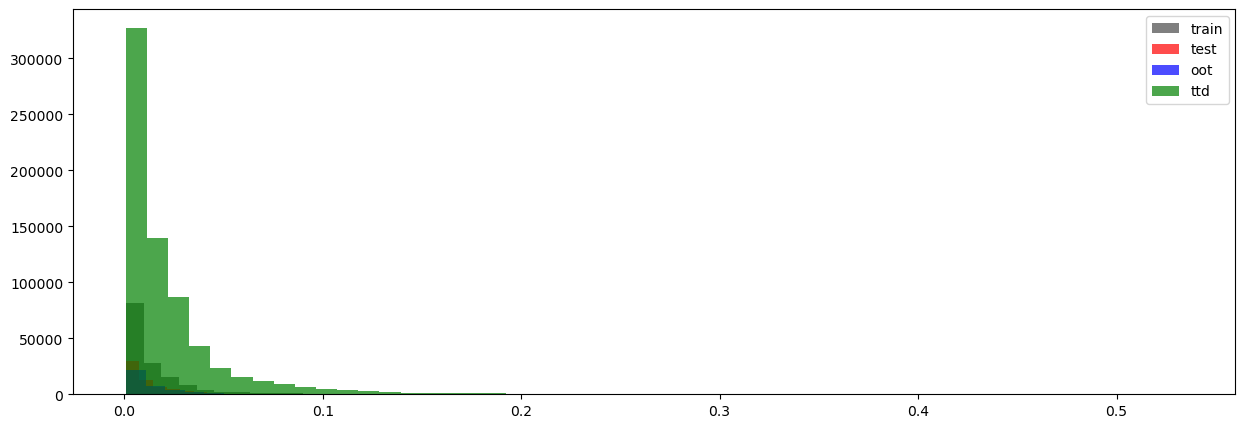

In [125]:
import matplotlib.pyplot as plt
plt.figure(figsize= (15, 5))
plt.hist(Train['p1'], bins= 50, label= 'train', color= 'black', alpha= 0.5)
plt.hist(Test['p1'], bins= 50, label= 'test', color= 'red', alpha= 0.7)
plt.hist(Oot['p1'], bins= 50, label= 'oot', color= 'blue', alpha= 0.7)
plt.hist(TTD['p1'], bins= 50, label= 'ttd', color= 'green', alpha= 0.7)
plt.legend()
plt.show()

In [126]:
Train['p1'].value_counts(dropna= False).head()

p1
0.029836    29
0.021679    18
0.003521    16
0.022350    15
0.004377    14
Name: count, dtype: int64

In [127]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
[0]     141943
[1]       4543
[2]        337
[-1]        32
Name: count, dtype: int64
bankruptcystatus
[0]     60829
[1]      1941
[2]       157
[-1]       11
Name: count, dtype: int64


In [128]:
def Bucket_Order(data):
    data['lower_bound'] = data['Bucket'].str.replace('[','').str.replace(']','').str.replace('(','').str.replace(')','').str.split(',').str[0]
    data['lower_bound'] = data['lower_bound'].apply(lambda x: -np.inf if x == '-inf' else np.inf if x == 'inf' else float(x))
    data = data.sort_values('lower_bound')
    a = data.loc[data['lower_bound']==-1]
    b = data.loc[data['lower_bound']!=-1]
    b['Is_Trend']= 'Yes' if (
            (b['Train_BadRate'].is_monotonic_decreasing and b['Test_BadRate'].is_monotonic_decreasing) or
            (b['Train_BadRate'].is_monotonic_increasing and b['Test_BadRate'].is_monotonic_increasing)
        ) else 'No'
    data = pd.concat(objs=[a,b])
    data = data.drop(columns=['lower_bound'])
    return data

In [129]:
df_bv= pd.DataFrame()

for col in col_list:
    print(col)
    ### Train
    temp_tr= Train.groupby(col).agg(
        bad_count_tr= ('bad_flag', 'sum'),
        bad_rate_tr= ('bad_flag', 'mean'),
                                p1_bad_rate_tr= ('p1', 'mean'),
                                   volume_tr= ('unique_id', 'count')).reset_index()
    temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_P1', 'Train_Count']
    temp_tr.insert(0, 'variable', col)
    
    # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
    # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
    # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
    # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
    ### Test
    temp_te= Test.groupby(col).agg(
        bad_count_te= ('bad_flag', 'sum'),
        bad_rate_te= ('bad_flag', 'mean'),
                                p1_bad_rate_te= ('p1', 'mean'),
                                  volume_te= ('unique_id', 'count')).reset_index()
    temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_P1', 'Test_Count']
    #temp_te['variable']= col
    
    # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
    # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
    # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
    # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
    ### Concatenating
    temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
    # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
    temp= Bucket_Order(temp)
    # display(temp)
    
    df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
    del temp, temp_tr, temp_te

assetownership
inquiryauto12month
inquiryshortterm12month
sourcenonderogcount12month
assetpropevercount
inquirytelcom12month
sourcenonderogcount
addrinputcountyratio
addrlastmovetaxratiodiff
inquirynonshortterm12month
derogcount
addrcurrenttaxmarketvalue
criminalnonfelonycount
addrinputtaxvalue
evictioncount
derogcount12month
addrprevioustimeoldest
sourcevoterregistration
addrinputtimenewest
educationinstitutionrating
addrcurrentavmvalue60month
criminalfelonycount
addrinputlengthofres
addrchangecount03month
educationevidence
addrlastmoveecontrajectory
inquirycollections12month
bankruptcydismissed24month
inquirybanking12month
bankruptcychapter
lienjudgmentcount
addrcurrentavmvalue
addrchangecount24month
addrcurrentdeedmailing
educationattendance
addrinputtaxmarketvalue
addrinputsubjectcount
addrpreviouslengthofres
addrinputdeedmailing
assetpersonal
bankruptcystatus
educationprogramattended
addrchangecount06month
criminalnonfelonycount12month
lienjudgmenttaxcount
addrinputavmvalue
assetp

In [130]:
pd.options.display.max_rows= 1000
df_bv

,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,assetownership,[0],1606.0,0.029652,0.030343,54162,691.0,0.029889,0.030511,23119.0,Yes
1,assetownership,[1],621.0,0.006700,0.007068,92693,268.0,0.006730,0.007056,39819.0,Yes
2,inquiryauto12month,[0],1496.0,0.011491,0.011964,130194,647.0,0.011612,0.011979,55716.0,Yes
3,inquiryauto12month,[1],731.0,0.043875,0.044470,16661,312.0,0.043201,0.044162,7222.0,Yes
4,inquiryshortterm12month,[0],2005.0,0.013959,0.014497,143630,882.0,0.014330,0.014545,61551.0,Yes
5,inquiryshortterm12month,[1],222.0,0.068837,0.067104,3225,77.0,0.055516,0.065679,1387.0,Yes
6,sourcenonderogcount12month,"[-inf, 2.0)",1730.0,0.023668,0.023975,73094,726.0,0.023263,0.024073,31209.0,Yes
7,sourcenonderogcount12month,"[2.0, inf)",497.0,0.006738,0.007404,73761,233.0,0.007343,0.007409,31729.0,Yes
8,assetpropevercount,"[-inf, 1.0)",1526.0,0.030046,0.030678,50788,663.0,0.030656,0.030820,21627.0,Yes
9,assetpropevercount,"[1.0, 2.0)",445.0,0.008564,0.008841,51963,204.0,0.009101,0.008904,22414.0,Yes


In [131]:
for client in Train['client'].unique():
    print(client)
    get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
                  data= Train[Train['client']== client], 
                  data_h2o= train_h2o[train_h2o['client']== client], 
                  target= 'bad_flag', 
                  cols_tuple= col_tuple_pass, 
                  score_col= 'p1', 
                  weight= 'conwt')
    

Tower
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
30041 572.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.019426,0.306773,0.038985,6009,5673.0,336.0,5.59,20.0,19.25,58.74,39.49
1,0.009873,0.019425,0.013976,6008,5876.0,132.0,2.20,40.0,39.19,81.82,42.63
2,0.005873,0.009872,0.007617,6008,5938.0,70.0,1.17,60.0,59.34,94.06,34.72
3,0.003713,0.005873,0.004728,6008,5984.0,24.0,0.40,80.0,79.65,98.25,18.60
4,0.000826,0.003713,0.002726,6008,5998.0,10.0,0.17,100.0,100.00,100.00,0.00


{'Gini': 54.17999999999999, 'KS': 42.63}
GESA
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
19768 402.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030249,0.309549,0.057416,3954,3724.0,230.0,5.82,20.0,19.23,57.21,37.98
1,0.018381,0.030244,0.023792,3954,3858.0,96.0,2.43,40.0,39.15,81.09,41.94
2,0.009725,0.018381,0.013800,3953,3901.0,52.0,1.32,60.0,59.29,94.03,34.74
3,0.005335,0.009724,0.007218,3954,3932.0,22.0,0.56,80.0,79.60,99.50,19.90
4,0.001064,0.005334,0.003716,3953,3951.0,2.0,0.05,100.0,100.00,100.00,0.00


{'Gini': 53.82, 'KS': 41.94}
Hawaii
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
1438 3.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.026344,0.228213,0.042559,288,286.0,2.0,0.69,20.03,19.93,66.67,46.74
1,0.017752,0.026328,0.021852,288,288.0,0.0,0.00,40.06,40.00,66.67,26.67
2,0.011399,0.017747,0.014185,287,287.0,0.0,0.00,60.01,60.00,66.67,6.67
3,0.006964,0.011375,0.009061,288,287.0,1.0,0.35,80.04,80.00,100.00,20.00
4,0.001500,0.006959,0.004538,287,287.0,0.0,0.00,100.00,100.00,100.00,0.00


{'Gini': 40.050000000000004, 'KS': 46.74}
Guardian
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
19177 268.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030833,0.425735,0.063497,3836,3668.0,168.0,4.38,20.0,19.40,62.69,43.29
1,0.016207,0.030817,0.022523,3835,3773.0,62.0,1.62,40.0,39.35,85.82,46.47
2,0.008509,0.016207,0.011926,3836,3815.0,21.0,0.55,60.0,59.53,93.66,34.13
3,0.004729,0.008509,0.006430,3835,3819.0,16.0,0.42,80.0,79.72,99.63,19.91
4,0.000908,0.004729,0.003296,3835,3834.0,1.0,0.03,100.0,100.00,100.00,0.00


{'Gini': 57.52, 'KS': 46.47}
SECU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
12804 320.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.029415,0.446030,0.062892,2561,2357.0,204.0,7.97,20.00,18.88,63.75,44.87
1,0.015410,0.029397,0.021693,2561,2496.0,65.0,2.54,40.00,38.87,84.06,45.19
2,0.008038,0.015407,0.011220,2561,2528.0,33.0,1.29,60.00,59.12,94.38,35.26
3,0.004608,0.008037,0.006177,2561,2550.0,11.0,0.43,80.01,79.55,97.81,18.26
4,0.001032,0.004608,0.003246,2560,2553.0,7.0,0.27,100.00,100.00,100.00,0.00


{'Gini': 57.43000000000001, 'KS': 45.19}
Arkansas
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
27867 167.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.010943,0.297318,0.025321,5574,5468.0,106.0,1.90,20.0,19.74,63.47,43.73
1,0.005826,0.010940,0.007898,5573,5543.0,30.0,0.54,40.0,39.75,81.44,41.69
2,0.003777,0.005826,0.004703,5574,5553.0,21.0,0.38,60.0,59.80,94.01,34.21
3,0.002458,0.003777,0.003076,5573,5567.0,6.0,0.11,80.0,79.90,97.60,17.70
4,0.000809,0.002458,0.001893,5573,5569.0,4.0,0.07,100.0,100.00,100.00,0.00


{'Gini': 54.93, 'KS': 43.73}
Numerica
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
18091 297.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.025361,0.444837,0.045955,3619,3469.0,150.0,4.14,20.0,19.50,50.51,31.01
1,0.014359,0.025357,0.019381,3618,3539.0,79.0,2.18,40.0,39.38,77.10,37.72
2,0.008427,0.014354,0.010973,3618,3579.0,39.0,1.08,60.0,59.50,90.24,30.74
3,0.005274,0.008427,0.006745,3618,3603.0,15.0,0.41,80.0,79.75,95.29,15.54
4,0.000965,0.005274,0.003841,3618,3604.0,14.0,0.39,100.0,100.00,100.00,0.00


{'Gini': 46.0, 'KS': 37.72}
CPM
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
6702 94.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.016866,0.399340,0.036952,1341,1287.0,54.0,4.03,20.01,19.48,57.45,37.97
1,0.008553,0.016856,0.011980,1340,1316.0,24.0,1.79,40.00,39.39,82.98,43.59
2,0.005174,0.008544,0.006658,1341,1330.0,11.0,0.82,60.01,59.52,94.68,35.16
3,0.003278,0.005173,0.004201,1340,1336.0,4.0,0.30,80.01,79.74,98.94,19.20
4,0.000933,0.003278,0.002412,1340,1339.0,1.0,0.07,100.00,100.00,100.00,0.00


{'Gini': 54.37, 'KS': 43.59}
Bethpage
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
8328 63.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.015180,0.215501,0.030510,1666,1642.0,24.0,1.44,20.00,19.87,38.10,18.23
1,0.008066,0.015178,0.011156,1666,1651.0,15.0,0.90,40.01,39.84,61.90,22.06
2,0.004804,0.008064,0.006257,1665,1650.0,15.0,0.90,60.00,59.81,85.71,25.90
3,0.002979,0.004803,0.003814,1666,1658.0,8.0,0.48,80.01,79.87,98.41,18.54
4,0.000821,0.002978,0.002237,1665,1664.0,1.0,0.06,100.00,100.00,100.00,0.00


{'Gini': 33.89, 'KS': 25.9}
HFCU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
2044 33.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.018350,0.188914,0.035050,409,396.0,13.0,3.18,20.01,19.69,39.39,19.70
1,0.009603,0.018339,0.013199,409,399.0,10.0,2.44,40.02,39.53,69.70,30.17
2,0.005306,0.009573,0.007211,409,402.0,7.0,1.71,60.03,59.52,90.91,31.39
3,0.003308,0.005296,0.004208,409,407.0,2.0,0.49,80.04,79.76,96.97,17.21
4,0.000861,0.003300,0.002414,408,407.0,1.0,0.25,100.00,100.00,100.00,0.00


{'Gini': 39.4, 'KS': 31.39}
NCU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
595 8.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024171,0.156164,0.046062,120,114.0,6.0,5.00,20.17,19.42,75.0,55.58
1,0.013122,0.023438,0.017886,118,117.0,1.0,0.85,40.00,39.35,87.5,48.15
2,0.007056,0.013017,0.009751,120,119.0,1.0,0.83,60.17,59.63,100.0,40.37
3,0.003894,0.007041,0.005226,119,119.0,0.0,0.00,80.17,79.90,100.0,20.10
4,0.001042,0.003872,0.002617,118,118.0,0.0,0.00,100.00,100.00,100.0,0.00


{'Gini': 65.72, 'KS': 55.58}


### Basic Checks

In [132]:
TTD['funded_flag'].sum(), Train['funded_flag'].sum(), Test['funded_flag'].sum()

(200148.0, 146855.0, 62938.0)

In [133]:
TTD['id']= TTD['unique_id']+TTD['client']
Train['id']= Train['unique_id']+Train['client']
Test['id']= Test['unique_id']+Test['client']
Oot['id']= Oot['unique_id']+Oot['client']

In [134]:
Train[(Train['id'].isin(TTD['id'].unique())) & (Train['client']!= 'CPM')].shape, Train[Train['client']!='CPM'].shape

((140153, 147), (140153, 147))

In [135]:
Test[(Test['id'].isin(TTD['id'].unique())) & (Test['client']!= 'CPM')].shape, Test[Test['client']!='CPM'].shape

((59995, 147), (59995, 147))

In [136]:
Train[(Train['id'].isin(Test['id'].unique()))].shape

(0, 147)

In [137]:
TTD[TTD['id'].isin(Train[Train['client']!= 'CPM']['id'].unique())]['p1'].describe(), Train[Train['client']!= 'CPM']['p1'].describe()

(count    140153.000000
 mean          0.015806
 std           0.021647
 min           0.000809
 25%           0.004295
 50%           0.008289
 75%           0.019114
 max           0.446030
 Name: p1, dtype: float64,
 count    140153.000000
 mean          0.015806
 std           0.021647
 min           0.000809
 25%           0.004295
 50%           0.008289
 75%           0.019114
 max           0.446030
 Name: p1, dtype: float64)

In [138]:
Train['client'].value_counts(dropna= False)

client
Tower       30041
Arkansas    27867
GESA        19768
Guardian    19177
Numerica    18091
SECU        12804
Bethpage     8328
CPM          6702
HFCU         2044
Hawaii       1438
NCU           595
Name: count, dtype: int64

In [139]:
import datetime
pref= 'Without_LDA'
# Train[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Train_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
# Test[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Test_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
# Oot[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Oot_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
# TTD[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_TTD_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)

In [140]:
TTD['fico_cut']= np.where(((TTD['fico_pb'].isnull()) |(TTD['fico_pb']<300)),"h.Missing",
                        np.where((TTD['fico_pb']>=300) &(TTD['fico_pb']<550),"a.300-550",
                                 np.where((TTD['fico_pb']>=550) &(TTD['fico_pb']<600),"a.550-600",
                                np.where((TTD['fico_pb']>=600) &(TTD['fico_pb']<630),"b.600-629",
                                    np.where((TTD['fico_pb']>=630) &(TTD['fico_pb']<660),"c.630-659",
                                        np.where((TTD['fico_pb']>=660) &(TTD['fico_pb']<690),"d.660-689",
                                            np.where((TTD['fico_pb']>=690) &(TTD['fico_pb']<715),"e.690-714",
                                                np.where((TTD['fico_pb']>=715) & (TTD['fico_pb']<740),"f.715-739",
                                                    np.where((TTD['fico_pb']>=740),"g.740+","h.Missing")))))))))

In [141]:
TTD.groupby('fico_cut').agg(
    ttd= ('unique_id', 'count'),
    approved= ('approve_flag', 'sum'),
    funded= ('funded_flag', 'sum'),
    bad= ('bad_flag', 'sum'),
    avg_pd= ('p1', 'mean')
)

,ttd,approved,funded,bad,avg_pd
fico_cut,,,,,
a.300-550,35333,2873.0,1857.0,126.0,0.051099
a.550-600,52785,13360.0,5376.0,346.0,0.040441
b.600-629,57138,23516.0,7940.0,386.0,0.032698
c.630-659,78628,39076.0,15179.0,554.0,0.026691
d.660-689,90338,52831.0,24815.0,511.0,0.021161
e.690-714,73120,48229.0,23877.0,300.0,0.017429
f.715-739,62889,45175.0,23083.0,186.0,0.015230
g.740+,199076,167515.0,93215.0,243.0,0.009539
h.Missing,35908,9030.0,4806.0,395.0,0.040030


In [142]:
TTD.shape

(685215, 148)